In [1]:
import numpy as np
import math
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import pickle
import csv
import tensorflow as tf
from sionna.channel.tr38901 import CDL, PanelArray
from sionna.channel import cir_to_time_channel

2025-07-27 16:26:40.330304: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 16:26:40.332114: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 16:26:40.363814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-27 16:26:40.363850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-27 16:26:40.364790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [9]:
# Helper Functions
class HelpFunc:
    @staticmethod
    def UnitQamConstellation(Bi):
        EvenSquareRoot = math.ceil(math.sqrt(2 ** Bi) / 2) * 2
        PamM = EvenSquareRoot
        PamConstellation = np.arange(-(PamM - 1), PamM, 2).astype(np.int32)
        PamConstellation = np.reshape(PamConstellation, (1, -1))
        SquareMatrix = np.matmul(np.ones((PamM, 1)), PamConstellation)
        C = SquareMatrix + 1j * (SquareMatrix.T)
        C_tmp = np.zeros(C.shape[0] * C.shape[1]).astype('complex128')
        for i in range(C.shape[1]):
            for j in range(C.shape[0]):
                C_tmp[i * C.shape[0] + j] = C[j][i]
        C = C_tmp
        return C / math.sqrt(np.mean(abs(C) ** 2))

    @staticmethod
    def ComputeChannelCorrMatrix(IsiMagnitude):
        N = len(IsiMagnitude)
        r_f_bold = np.fft.fft(IsiMagnitude)
        r_f_bold_prime = r_f_bold[1:][::-1]
        r_f_bold_conj = np.conjugate(r_f_bold)
        r_f_bold_ext = np.append(r_f_bold_prime, r_f_bold_conj)
        R_f = np.zeros((N, N)).astype('complex128')
        for k in range(0, N):
            R_f[N - k - 1, :] = r_f_bold_ext[k: N + k]
        return R_f

    @staticmethod
    def trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP, x_CP):
        if DelayFlag:
            Delay_LUT = np.zeros(((Max_Delay + 1 - Min_Delay) ** 4, 4)).astype('int32')
            count = 0
            temp = np.zeros(Delay_LUT.shape[0])
            for ii in range(Min_Delay, Max_Delay + 1):
                for jj in range(Min_Delay, Max_Delay + 1):
                    for kk in range(Min_Delay, Max_Delay + 1):
                        for ll in range(Min_Delay, Max_Delay + 1):
                            Delay_LUT[count, :] = np.array([ii, jj, kk, ll])
                            if (abs(ii - jj) > 2 or abs(kk - ll) > 2 or abs(ii - kk) > 2 or
                                abs(ii - ll) > 2 or abs(jj - kk) > 2 or abs(jj - ll) > 2):
                                temp[count] = 1
                            count += 1
            Delay_LUT = np.delete(Delay_LUT, np.where(temp > 0)[0], axis=0)
        else:
            Delay_LUT = np.zeros((Max_Delay - Min_Delay + 1, 4)).astype('int32')
            for jjjj in range(Min_Delay, Max_Delay + 1):
                Delay_LUT[jjjj - Min_Delay, :] = jjjj * np.ones(4)

        Delay_Max = np.amax(Delay_LUT, axis=1)
        Delay_Min = np.amin(Delay_LUT, axis=1)
        NMSE_ESN_Training = np.zeros(Delay_LUT.shape[0])
        for jjj in range(Delay_LUT.shape[0]):
            Curr_Delay = Delay_LUT[jjj, :]
            ESN_input = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, N_t * 2))
            ESN_output = np.zeros((N + Delay_Max[jjj] + CyclicPrefixLen, N_t * 2))
            ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max[jjj]))
            ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max[jjj]))
            ESN_output[Curr_Delay[0]: Curr_Delay[0] + N + CyclicPrefixLen, 0] = x_CP[:, 0].real
            ESN_output[Curr_Delay[1]: Curr_Delay[1] + N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
            ESN_output[Curr_Delay[2]: Curr_Delay[2] + N + CyclicPrefixLen, 2] = x_CP[:, 1].real
            ESN_output[Curr_Delay[3]: Curr_Delay[3] + N + CyclicPrefixLen, 3] = x_CP[:, 1].imag
            nForgetPoints = Delay_Min[jjj] + CyclicPrefixLen
            esn.fit(ESN_input, ESN_output, nForgetPoints)
            x_hat_ESN_temp = esn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
            x_hat_ESN_0 = x_hat_ESN_temp[Curr_Delay[0] - Delay_Min[jjj]: Curr_Delay[0] - Delay_Min[jjj] + N + 1, 0] + 1j * x_hat_ESN_temp[Curr_Delay[1] - Delay_Min[jjj]: Curr_Delay[1] - Delay_Min[jjj] + N + 1, 1]
            x_hat_ESN_1 = x_hat_ESN_temp[Curr_Delay[2] - Delay_Min[jjj]: Curr_Delay[2] - Delay_Min[jjj] + N + 1, 2] + 1j * x_hat_ESN_temp[Curr_Delay[3] - Delay_Min[jjj]: Curr_Delay[3] - Delay_Min[jjj] + N + 1, 3]
            x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
            x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
            x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
            x = x_CP[IsiDuration - 1:, :]
            NMSE_ESN_Training[jjj] = (
                np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
                np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
            )
        Delay_Idx = np.argmin(NMSE_ESN_Training)
        NMSE_ESN = np.min(NMSE_ESN_Training)
        Delay = Delay_LUT[Delay_Idx, :]
        ESN_input = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, N_t * 2))
        ESN_output = np.zeros((N + Delay_Max[Delay_Idx] + CyclicPrefixLen, N_t * 2))
        ESN_input[:, 0] = np.append(y_CP[:, 0].real, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 1] = np.append(y_CP[:, 0].imag, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 2] = np.append(y_CP[:, 1].real, np.zeros(Delay_Max[Delay_Idx]))
        ESN_input[:, 3] = np.append(y_CP[:, 1].imag, np.zeros(Delay_Max[Delay_Idx]))
        ESN_output[Delay[0]: Delay[0] + N + CyclicPrefixLen, 0] = x_CP[:, 0].real
        ESN_output[Delay[1]: Delay[1] + N + CyclicPrefixLen, 1] = x_CP[:, 0].imag
        ESN_output[Delay[2]: Delay[2] + N + CyclicPrefixLen, 2] = x_CP[:, 1].real
        ESN_output[Delay[3]: Delay[3] + N + CyclicPrefixLen, 3] = x_CP[:, 1].imag
        nForgetPoints = Delay_Min[Delay_Idx] + CyclicPrefixLen
        esn.fit(ESN_input, ESN_output, nForgetPoints)
        Delay_Minn = Delay_Min[Delay_Idx]
        Delay_Maxx = Delay_Max[Delay_Idx]
        return [ESN_input, ESN_output, esn, Delay, Delay_Idx, Delay_Minn, Delay_Maxx, nForgetPoints, NMSE_ESN]

In [3]:
def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s

def identity(x):
    return x

class ESN:
    def __init__(self, n_inputs, n_outputs, n_reservoir=200, spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None, teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity, random_state=None, silent=True):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)
        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift
        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            self.random_state_ = np.random.RandomState(random_state)
        else:
            self.random_state_ = np.random.mtrand._rand
        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
        self.W_in = self.random_state_.rand(self.n_reservoir, self.n_inputs) * 2 - 1
        self.W_feedb = self.random_state_.rand(self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern) + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        return np.tanh(preactivation) + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5)

    def _scale_inputs(self, inputs):
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, nForgetPoints=0, inspect=False):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :], teachers_scaled[n - 1, :])
        transient = max(0, nForgetPoints)
        extended_states = np.hstack((states, inputs_scaled))
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]), self.inverse_out_activation(teachers_scaled[transient:, :])).T
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
        pred_train = self._unscale_teacher(self.out_activation(np.dot(extended_states, self.W_out.T)))
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]
        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)
        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack([laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack([lastoutput, np.zeros((n_samples, self.n_outputs))])
        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out, np.concatenate([states[n + 1, :], inputs[n + 1, :]])))
        return self._unscale_teacher(self.out_activation(outputs[1:]))

In [4]:

# Sionna Channel Setup
carrier_frequency = 3.5e9  # Carrier frequency in Hz
delay_spread = 300e-9  # RMS delay spread in seconds

# Sionna Channel Setup
N_r, N_t = 2, 2
carrier_frequency = 3.5e9

bs_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='dual',
    polarization_type='VH',
    antenna_pattern='38.901',
    carrier_frequency=carrier_frequency,
)

ut_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='dual',
    polarization_type='VH',
    antenna_pattern='omni',
    carrier_frequency=carrier_frequency,
)

delay_spread = 300e-9  # 300 ns
cdl = CDL(
    model="C",
    delay_spread=delay_spread,
    carrier_frequency=carrier_frequency,
    ut_array=ut_array,
    bs_array=bs_array,
    direction="downlink",
    min_speed=0.,
    max_speed=0.,
    dtype=tf.complex64
)
# Precompute IsiMagnitude using the CDL-C cluster parameters
cluster_delays_ns = np.array([0, 76.6135, 80.9935, 85.0085, 79.424, 232.359, 235.352, 239.44, 240.316, 289.6275, 299.7745, 340.764, 448.4025, 477.5295, 792.196, 989.3325, 1554.4985, 1679.1095, 2003.923, 2046.8105, 2301.8725])
cluster_powers_db = np.array([-4.4215, -1.25, -3.4684, -5.2294, -2.5215, 0, -2.2185, -3.9794, -7.4215, -7.1215, -10.7215, -11.1215, -5.1215, -6.8215, -8.7215, -13.2215, -13.9215, -13.9215, -15.8215, -17.1215, -16.0215])
cluster_powers_lin = 10 ** (cluster_powers_db / 10)
cluster_powers_lin /= np.sum(cluster_powers_lin)  # Normalize to sum 1

tau = cluster_delays_ns * 1e-9  # Convert to seconds

# Bandwidth W will be defined later, but for computation, assume it's known or compute symbolically, but since W is fixed, we can compute after parameters

# Physical Parameters
W = 2 * 1.024e6  # Bandwidth in Hz
f_D = 100  # Doppler Frequency in Hz
No = 0.00001  # Noise PSD in W/Hz
IsiDuration = 8  # Number of multipath taps (fixed to match original)
cFlag = False  # Fixed CIR flag (not used in Sionna adaptation)
EbNoDB = np.arange(25, 30 + 1, 5).astype(np.int32)  # SNR range in dB

# MIMO Parameters
N_t = 2  # Transmit antennas
N_r = 2  # Receive antennas

# Design Parameters
N = 64  # Number of subcarriers
Subcarrier_Spacing = W / N
m = 4  # Data QAM order (bits per symbol)
m_pilot = 4  # Pilot QAM order
NumOfdmSymbols = 1000  # Symbols to simulate
Ptotal = 10 ** (EbNoDB / 10) * No * N  # Total power

# Power Amplifier Parameters
p_smooth = 1
ClipLeveldB = 3

# Secondary Parameters
T_OFDM = N / W  # OFDM symbol duration
T_OFDM_Total = (N + IsiDuration - 1) / W  # Including CP
T_s = 1 / W  # Sampling period
tau_c = 0.5 / f_D  # Channel coherence time
L = math.floor(tau_c / T_OFDM_Total)  # Coherence in symbols
Pi = Ptotal / N  # Power per subcarrier
NumBitsPerSymbol = m * N
Const = HelpFunc.UnitQamConstellation(m)  # Data constellation
ConstPilot = HelpFunc.UnitQamConstellation(m_pilot)  # Pilot constellation
PowersOfTwo = np.power(2, np.arange(m)).reshape((1, -1))
CyclicPrefixLen = IsiDuration - 1

# Compute IsiMagnitude (PDP) for CDL-C
l_min = 0  # Assuming min delay 0
l_max = IsiDuration - 1
IsiMagnitude = np.zeros(IsiDuration)
for k in range(IsiDuration):
    x = tau * W - k
    sinc_vals = np.sinc(x)  # np.sinc(x) = sin(pi x) / (pi x)
    IsiMagnitude[k] = np.sum(cluster_powers_lin * sinc_vals ** 2)

# Normalize if necessary (should already sum to approx 1)
IsiMagnitude /= np.sum(IsiMagnitude)

print("Computed IsiMagnitude:", IsiMagnitude)

# ESN Parameters
var_x = np.power(10, (EbNoDB / 10)) * No * N
nInputUnits = N_t * 2
nOutputUnits = N_t * 2
nInternalUnits = 5000
inputScaler = 0.005
inputOffset = 0.0
feedbackScaler = 0.0
teacherScaling = 0.0000005 * np.ones(N_t * 2)
spectralRadius = 0.9
teacherShift = np.zeros(N_t * 2)
feedbackScaling = feedbackScaler * np.ones(N_t * 2)
Min_Delay = 0
Max_Delay = math.ceil(IsiDuration / 2) + 2
DelayFlag = 0

# Initialize Arrays
ESN_train_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_train_teacher = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_output = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
BER_ESN = np.zeros(len(EbNoDB))
BER_Perfect = np.zeros(len(EbNoDB))
BER_LS = np.zeros(len(EbNoDB))
BER_MMSE = np.zeros(len(EbNoDB))
NMSE_ESN_Testing = np.zeros(len(EbNoDB))
NMSE_ESN_Training = np.zeros(len(EbNoDB))
c = [[None] * N_t for _ in range(N_r)]
Ci = [[None] * N_t for _ in range(N_r)]
Ci_LS = [[None] * N_t for _ in range(N_r)]
Ci_MMSE = [[None] * N_t for _ in range(N_r)]
Ci_LS_Pilots = [[None] * N_t for _ in range(N_r)]
MMSEScaler = No / Pi
R_h = np.zeros((IsiDuration, IsiDuration))
for ii in range(IsiDuration):
    R_h[ii, ii] = IsiMagnitude[ii]

# Data Flow Check
print("=== Parameter Initialization ===")
print(f"EbNoDB: {EbNoDB}")
print(f"Ptotal shape: {Ptotal.shape}, values: {Ptotal}")
print(f"Subcarrier Spacing: {Subcarrier_Spacing:.2e} Hz")
print(f"Coherence Length (L): {L} symbols")
print(f"ISI Magnitude shape: {IsiMagnitude.shape}, first few values: {IsiMagnitude[:3]}")
print(f"Data Constellation shape: {Const.shape}, first few points: {Const[:3]}")
print(f"BER Arrays shape: {BER_ESN.shape}")
print(f"Channel Matrix (R_h) shape: {R_h.shape}, diagonal: {np.diag(R_h)}")

Computed IsiMagnitude: [0.60298795 0.30221634 0.04787873 0.0203715  0.01578569 0.0069627
 0.00227861 0.00151848]
=== Parameter Initialization ===
EbNoDB: [25 30]
Ptotal shape: (2,), values: [0.20238577 0.64      ]
Subcarrier Spacing: 3.20e+04 Hz
Coherence Length (L): 144 symbols
ISI Magnitude shape: (8,), first few values: [0.60298795 0.30221634 0.04787873]
Data Constellation shape: (16,), first few points: [-0.9486833-0.9486833j  -0.9486833-0.31622777j -0.9486833+0.31622777j]
BER Arrays shape: (2,)
Channel Matrix (R_h) shape: (8, 8), diagonal: [0.60298795 0.30221634 0.04787873 0.0203715  0.01578569 0.0069627
 0.00227861 0.00151848]


In [5]:
# Select first SNR
jj = 0
print(f"\n=== Processing SNR: EbNoDB = {EbNoDB[jj]} dB ===")

# SNR-specific parameters
A_Clip = np.sqrt(var_x[jj]) * np.float_power(10, ClipLeveldB / 20)
inputScaling = inputScaler / (var_x[jj] ** 0.5) * np.ones(N_t * 2)
inputShift = inputOffset / inputScaler * np.ones(N_t * 2)
TotalBerNum_ESN = 0
TotalBerNum_LS = 0
TotalBerNum_MMSE = 0
TotalBerNum_Perfect = 0
TotalBerDen = 0
MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj] / (N / 2) * np.eye(IsiDuration))

# Process one pilot symbol (kk=1)
kk = 1
print(f"Processing pilot symbol {kk}")

# Channel Generation using Sionna CDL
batch_size = 1  # Single realization for static channel
num_time_samples = 1  # Static channel, no need for multiple time steps
a, tau = cdl(batch_size, num_time_samples, W)
a = a.numpy()
tau = tau.numpy()

# Compute discrete-time channel impulse response
h_time = cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
h_time = h_time.numpy()

# Store channel for LS and MMSE estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        c[nnn][mmm] = h_time[0, 0, nnn, 0, mmm, 0, :]  # batch=0, rx=0, rx_ant=nnn, tx=0, tx_ant=mmm, time=0, taps=:
        Ci[nnn][mmm] = np.fft.fft(np.append(c[nnn][mmm], np.zeros(N - IsiDuration)))

# Pilot Transmission
TxBits = (np.random.uniform(0, 1, size=(N * m_pilot, N_t)) > 0.5).astype(np.int32)
X = np.zeros((N, N_t)).astype('complex128')
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
for ii in range(N):
    for iii in range(N_t):
        ThisQamIdx = np.matmul(PowersOfTwo[:m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot), iii])
        X[ii, iii] = ConstPilot[ThisQamIdx[0]]
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Nonlinear PA
x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

# Channel and Noise
y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
        y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt((N + CyclicPrefixLen) * No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_CP_NLD[:, nnn] += noise
Y = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

# Orthogonal Pilots for LS
X_LS = X.copy()
X_LS[np.arange(1, len(X_LS), 2), 0] = 0  # Tx1: even subcarriers
X_LS[np.arange(0, len(X_LS), 2), 1] = 0  # Tx2: odd subcarriers
x_LS_CP = np.zeros(x_CP.shape).astype('complex128')
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X_LS[:, iii])
    x_LS_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_LS_CP[:, iii] = x_LS_CP[:, iii] * (Pi[jj] ** 0.5)
y_LS_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_LS_CP[:, mmm], h_cdl, mode='full')
        y_LS_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt((N + CyclicPrefixLen) * No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_LS_CP[:, nnn] += noise
Y_LS = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y_LS[:, nnn] = 1 / N * np.fft.fft(y_LS_CP[IsiDuration - 1:, nnn])
Y_LS = Y_LS / (Pi[jj] ** 0.5)

# LS and MMSE Channel Estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        Ci_LS_Pilots[nnn][mmm] = Y_LS[np.arange(mmm, len(Y_LS), 2), nnn] / X_LS[np.arange(mmm, len(X_LS), 2), mmm]
        c_LS = np.fft.ifft(Ci_LS_Pilots[nnn][mmm])[:IsiDuration]
        c_MMSE = np.matmul(MMSE_bold_TD, c_LS)
        Ci_MMSE[nnn][mmm] = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))
        interp_x = np.append(np.arange(mmm, N, N_t), N - 1 if mmm == 0 else np.arange(mmm, N, N_t))
        interp_y = np.append(Ci_LS_Pilots[nnn][mmm], Ci_LS_Pilots[nnn][mmm][-1] if mmm == 0 else Ci_LS_Pilots[nnn][mmm])
        if mmm > 0:
            interp_x = np.append(0, interp_x)
            interp_y = np.append(Ci_LS_Pilots[nnn][mmm][0], interp_y)
        tmpf = interpolate.interp1d(interp_x, interp_y)
        Ci_LS[nnn][mmm] = tmpf(np.arange(N))

# ESN Training
esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
          sparsity=1 - min(0.2 * nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling,
          teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
[ESN_input, ESN_output, trainedEsn, Delay, Delay_Idx, Delay_Min, Delay_Max, nForgetPoints, NMSE_ESN] = \
    HelpFunc.trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP_NLD, x_CP)
ESN_train_input[kk - 1][jj] = ESN_input
ESN_train_teacher[kk - 1][jj] = ESN_output
NMSE_ESN_Training[jj] += NMSE_ESN

# Data Flow Check
print("\n=== Pilot Symbol Data Flow ===")
print(f"Channel c[0][0] shape: {c[0][0].shape}, first few taps: {c[0][0][:3]}")
print(f"Frequency response Ci[0][0] shape: {Ci[0][0].shape}, first few values: {Ci[0][0][:3]}")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y shape: {Y.shape}, first few symbols: {Y[:3, :]}")
print(f"LS Estimated Ci_LS[0][0] shape: {Ci_LS[0][0].shape}, first few values: {Ci_LS[0][0][:3]}")
print(f"MMSE Estimated Ci_MMSE[0][0] shape: {Ci_MMSE[0][0].shape}, first few values: {Ci_MMSE[0][0][:3]}")
print(f"ESN Input shape: {ESN_input.shape}, first few values: {ESN_input[:3, :]}")
print(f"ESN Output shape: {ESN_output.shape}, first few values: {ESN_output[:3, :]}")
print(f"ESN NMSE Training: {NMSE_ESN}")
print(f"Optimal Delays: {Delay}, Delay Index: {Delay_Idx}")


=== Processing SNR: EbNoDB = 25 dB ===
Processing pilot symbol 1

=== Pilot Symbol Data Flow ===
Channel c[0][0] shape: (8,), first few taps: [ 0.7586906 -0.20710537j  0.55709255+0.05992756j -0.1414935 +0.03347118j]
Frequency response Ci[0][0] shape: (64,), first few values: [1.25037311-0.11575596j 1.25567399-0.16917462j 1.25170218-0.21775058j]
Transmitted X shape: (64, 2), first few symbols: [[ 0.31622777+0.31622777j  0.9486833 -0.31622777j]
 [ 0.9486833 -0.31622777j -0.31622777+0.9486833j ]
 [-0.9486833 +0.9486833j  -0.9486833 +0.31622777j]]
Received Y shape: (64, 2), first few symbols: [[ 0.03766592-0.01327383j -0.05456094-0.04798092j]
 [ 0.05203722-0.00729482j  0.0369393 +0.01390224j]
 [-0.06264317+0.08898194j  0.05310949+0.03056221j]]
LS Estimated Ci_LS[0][0] shape: (64,), first few values: [1.29136471-0.18645689j 1.26372588-0.17918231j 1.23608705-0.17190774j]
MMSE Estimated Ci_MMSE[0][0] shape: (64,), first few values: [14.15343004 +3.2002787j  13.53217408 -5.49704482j
  7.43765

In [6]:
# Select first SNR
jj = 0
print(f"\n=== Processing SNR: EbNoDB = {EbNoDB[jj]} dB ===")

# SNR-specific parameters
A_Clip = np.sqrt(var_x[jj]) * np.float_power(10, ClipLeveldB / 20)
inputScaling = inputScaler / (var_x[jj] ** 0.5) * np.ones(N_t * 2)
inputShift = inputOffset / inputScaler * np.ones(N_t * 2)
TotalBerNum_ESN = 0
TotalBerNum_LS = 0
TotalBerNum_MMSE = 0
TotalBerNum_Perfect = 0
TotalBerDen = 0
MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj] / (N * (N / 2)) * np.eye(IsiDuration))

# Process one pilot symbol (kk=1)
kk = 1
print(f"Processing pilot symbol {kk}")

# Channel Generation using Sionna CDL
batch_size = 1  # Single realization for static channel
num_time_samples = 1  # Static channel, no need for multiple time steps
a, tau = cdl(batch_size, num_time_samples, W)
a = a.numpy()
tau = tau.numpy()

# Compute discrete-time channel impulse response
h_time = cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
h_time = h_time.numpy()

# Store channel for LS and MMSE estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        c[nnn][mmm] = h_time[0, 0, nnn, 0, mmm, 0, :]  # batch=0, rx=0, rx_ant=nnn, tx=0, tx_ant=mmm, time=0, taps=:
        Ci[nnn][mmm] = np.fft.fft(np.append(c[nnn][mmm], np.zeros(N - IsiDuration)))

# Pilot Transmission
TxBits = (np.random.uniform(0, 1, size=(N * m_pilot, N_t)) > 0.5).astype(np.int32)
X = np.zeros((N, N_t)).astype('complex128')
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
for ii in range(N):
    for iii in range(N_t):
        ThisQamIdx = np.matmul(PowersOfTwo[:m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot), iii])
        X[ii, iii] = ConstPilot[ThisQamIdx[0]]
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Nonlinear PA
x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

# Channel and Noise
y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
        y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_CP_NLD[:, nnn] += noise
Y = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

# Orthogonal Pilots for LS
X_LS = X.copy()
X_LS[np.arange(1, len(X_LS), 2), 0] = 0  # Tx1: even subcarriers
X_LS[np.arange(0, len(X_LS), 2), 1] = 0  # Tx2: odd subcarriers
x_LS_CP = np.zeros(x_CP.shape).astype('complex128')
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X_LS[:, iii])
    x_LS_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_LS_CP[:, iii] = x_LS_CP[:, iii] * (Pi[jj] ** 0.5)
y_LS_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_LS_CP[:, mmm], h_cdl, mode='full')
        y_LS_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_LS_CP[:, nnn] += noise
Y_LS = np.zeros((N, N_r)).astype('complex128')
for nnn in range(N_r):
    Y_LS[:, nnn] = 1 / N * np.fft.fft(y_LS_CP[IsiDuration - 1:, nnn])
Y_LS = Y_LS / (Pi[jj] ** 0.5)

# LS and MMSE Channel Estimation
for nnn in range(N_r):
    for mmm in range(N_t):
        Ci_LS_Pilots[nnn][mmm] = Y_LS[np.arange(mmm, len(Y_LS), 2), nnn] / X_LS[np.arange(mmm, len(X_LS), 2), mmm]
        c_LS = np.fft.ifft(Ci_LS_Pilots[nnn][mmm])[:IsiDuration]
        c_MMSE = np.matmul(R_h, np.matmul(MMSE_bold_TD, c_LS))
        Ci_MMSE[nnn][mmm] = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))
        interp_x = np.append(np.arange(mmm, N, N_t), N - 1 if mmm == 0 else np.arange(mmm, N, N_t))
        interp_y = np.append(Ci_LS_Pilots[nnn][mmm], Ci_LS_Pilots[nnn][mmm][-1] if mmm == 0 else Ci_LS_Pilots[nnn][mmm])
        if mmm > 0:
            interp_x = np.append(0, interp_x)
            interp_y = np.append(Ci_LS_Pilots[nnn][mmm][0], interp_y)
        tmpf = interpolate.interp1d(interp_x, interp_y)
        Ci_LS[nnn][mmm] = tmpf(np.arange(N))

# ESN Training
esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
          sparsity=1 - min(0.2 * nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling,
          teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
[ESN_input, ESN_output, trainedEsn, Delay, Delay_Idx, Delay_Min, Delay_Max, nForgetPoints, NMSE_ESN] = \
    HelpFunc.trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP_NLD, x_CP)
ESN_train_input[kk - 1][jj] = ESN_input
ESN_train_teacher[kk - 1][jj] = ESN_output
NMSE_ESN_Training[jj] += NMSE_ESN

# Data Flow Check
print("\n=== Pilot Symbol Data Flow ===")
print(f"Channel c[0][0] shape: {c[0][0].shape}, first few taps: {c[0][0][:3]}")
print(f"Frequency response Ci[0][0] shape: {Ci[0][0].shape}, first few values: {Ci[0][0][:3]}")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y shape: {Y.shape}, first few symbols: {Y[:3, :]}")
print(f"LS Estimated Ci_LS[0][0] shape: {Ci_LS[0][0].shape}, first few values: {Ci_LS[0][0][:3]}")
print(f"MMSE Estimated Ci_MMSE[0][0] shape: {Ci_MMSE[0][0].shape}, first few values: {Ci_MMSE[0][0][:3]}")
print(f"ESN Input shape: {ESN_input.shape}, first few values: {ESN_input[:3, :]}")
print(f"ESN Output shape: {ESN_output.shape}, first few values: {ESN_output[:3, :]}")
print(f"ESN NMSE Training: {NMSE_ESN}")
print(f"Optimal Delays: {Delay}, Delay Index: {Delay_Idx}")


=== Processing SNR: EbNoDB = 25 dB ===
Processing pilot symbol 1

=== Pilot Symbol Data Flow ===
Channel c[0][0] shape: (8,), first few taps: [ 0.0870522 +0.1897694j  0.1193601 +0.3316564j -0.01370471-0.0861289j]
Frequency response Ci[0][0] shape: (64,), first few values: [0.17858167+0.48692229j 0.21205997+0.47884086j 0.24248366+0.46394546j]
Transmitted X shape: (64, 2), first few symbols: [[ 0.31622777-0.31622777j  0.9486833 -0.31622777j]
 [-0.9486833 -0.9486833j  -0.9486833 +0.9486833j ]
 [ 0.31622777-0.9486833j   0.9486833 -0.31622777j]]
Received Y shape: (64, 2), first few symbols: [[-0.02631709+0.00696774j -0.00518888+0.05254986j]
 [ 0.04022266-0.05909485j  0.06559688-0.15041367j]
 [-0.01315935+0.00357318j  0.04248089+0.04294725j]]
LS Estimated Ci_LS[0][0] shape: (64,), first few values: [0.18731123+0.49764773j 0.21442831+0.47928912j 0.24154539+0.46093052j]
MMSE Estimated Ci_MMSE[0][0] shape: (64,), first few values: [0.17949996+0.48947202j 0.21335645+0.48123153j 0.2440453 +0.466

In [108]:
# Process one data symbol (kk=10, after pilot)
kk = 10
print(f"\n=== Processing data symbol {kk} ===")

# Data Transmission
TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
X = np.zeros((N, N_t)).astype('complex128')
x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
for ii in range(N):
    for iii in range(N_t):
        ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
        X[ii, iii] = Const[ThisQamIdx[0]]
for iii in range(N_t):
    x_temp = N * np.fft.ifft(X[:, iii])
    x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
    x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

# Nonlinear PA
x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

# Reception
Y_NLD = np.zeros((N, N_r)).astype('complex128')
y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
for nnn in range(N_r):
    for mmm in range(N_t):
        h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
        conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
        y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
    noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
    y_CP_NLD[:, nnn] += noise
for nnn in range(N_r):
    Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

# ESN Detection
ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
nForgetPoints = Delay_Min + CyclicPrefixLen
x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N, 3]
x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
x = x_CP[IsiDuration - 1:, :]
NMSE_ESN_Testing[jj] += (
    np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
    np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
)
X_hat_ESN = np.zeros(X.shape).astype('complex128')
for ii in range(N_t):
    X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
ESN_test_input[kk - 1][jj] = ESN_input
ESN_test_output[kk - 1][jj] = x_hat_ESN

# Classical Detection
H_temp = np.zeros((N_r, N_t)).astype('complex128')
H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
X_hat_Perfect = np.zeros(X.shape).astype('complex128')
X_hat_LS = np.zeros(X.shape).astype('complex128')
X_hat_MMSE = np.zeros(X.shape).astype('complex128')
for ii in range(N):
    Y_temp = np.transpose(Y_NLD[ii, :])
    for nnn in range(N_r):
        for mmm in range(N_t):
            H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
            H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
            H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
    X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
    X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
    X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

# Bit Detection
RxBits_ESN = np.zeros(TxBits.shape)
RxBits_LS = np.zeros(TxBits.shape)
RxBits_MMSE = np.zeros(TxBits.shape)
RxBits_Perfect = np.zeros(TxBits.shape)
for ii in range(N):
    for iii in range(N_t):
        # Perfect
        ThisQamIdx = np.argmin(np.absolute(Const - X_hat_Perfect[ii, iii]))
        ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
        ThisBits = np.array([int(i) for i in ThisBits])[::-1]
        RxBits_Perfect[m * ii: m * (ii + 1), iii] = ThisBits
        # ESN
        ThisQamIdx = np.argmin(np.absolute(Const - X_hat_ESN[ii, iii]))
        ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
        ThisBits = np.array([int(i) for i in ThisBits])[::-1]
        RxBits_ESN[m * ii: m * (ii + 1), iii] = ThisBits
        # LS
        ThisQamIdx = np.argmin(np.absolute(Const - X_hat_LS[ii, iii]))
        ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
        ThisBits = np.array([int(i) for i in ThisBits])[::-1]
        RxBits_LS[m * ii: m * (ii + 1), iii] = ThisBits
        # MMSE
        ThisQamIdx = np.argmin(np.absolute(Const - X_hat_MMSE[ii, iii]))
        ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
        ThisBits = np.array([int(i) for i in ThisBits])[::-1]
        RxBits_MMSE[m * ii: m * (ii + 1), iii] = ThisBits

# Accumulate BER
TotalBerNum_ESN += np.sum(TxBits != RxBits_ESN)
TotalBerNum_LS += np.sum(TxBits != RxBits_LS)
TotalBerNum_MMSE += np.sum(TxBits != RxBits_MMSE)
TotalBerNum_Perfect += np.sum(TxBits != RxBits_Perfect)
TotalBerDen += NumBitsPerSymbol * N_t

# Data Flow Check
print("\n=== Data Symbol Data Flow ===")
print(f"Transmitted X shape: {X.shape}, first few symbols: {X[:3, :]}")
print(f"Received Y_NLD shape: {Y_NLD.shape}, first few symbols: {Y_NLD[:3, :]}")
print(f"ESN Estimated X_hat_ESN shape: {X_hat_ESN.shape}, first few symbols: {X_hat_ESN[:3, :]}")
print(f"Perfect Estimated X_hat_Perfect shape: {X_hat_Perfect.shape}, first few symbols: {X_hat_Perfect[:3, :]}")
print(f"LS Estimated X_hat_LS shape: {X_hat_LS.shape}, first few symbols: {X_hat_LS[:3, :]}")
print(f"MMSE Estimated X_hat_MMSE shape: {X_hat_MMSE.shape}, first few symbols: {X_hat_MMSE[:3, :]}")
print(f"ESN NMSE Testing: {NMSE_ESN_Testing[jj]}")
print(f"Bit Errors (this symbol) - ESN: {np.sum(TxBits != RxBits_ESN)}, LS: {np.sum(TxBits != RxBits_LS)}, MMSE: {np.sum(TxBits != RxBits_MMSE)}, Perfect: {np.sum(TxBits != RxBits_Perfect)}")
print(f"Total Bits: {TotalBerDen}")


=== Processing data symbol 10 ===

=== Data Symbol Data Flow ===
Transmitted X shape: (64, 2), first few symbols: [[ 0.9486833 +0.31622777j  0.9486833 -0.9486833j ]
 [-0.31622777+0.9486833j  -0.9486833 +0.31622777j]
 [-0.31622777+0.9486833j  -0.31622777+0.9486833j ]]
Received Y_NLD shape: (64, 2), first few symbols: [[ 0.05372251-0.01917962j -0.01909082+0.00171316j]
 [ 0.01190312-0.01601699j  0.07517994-0.00309788j]
 [-0.01998578+0.00996748j  0.03936318-0.05007683j]]
ESN Estimated X_hat_ESN shape: (64, 2), first few symbols: [[ 1.00458666+0.28050071j  0.89574883-0.53914093j]
 [-0.5771346 +1.2504625j  -1.0069661 +0.22066211j]
 [ 0.1475312 +0.78339199j -0.27196848+1.1025777j ]]
Perfect Estimated X_hat_Perfect shape: (64, 2), first few symbols: [[ 0.67885574+0.22516022j  0.55911016-0.6092788j ]
 [-0.26942574+0.79874034j -0.67342196+0.13033679j]
 [-0.03465714+0.58206394j -0.3139503 +0.79624472j]]
LS Estimated X_hat_LS shape: (64, 2), first few symbols: [[ 0.68494233+0.24130902j  0.5740501


=== Processing data symbol 3 ===
Bit Errors (this symbol) - ESN: 68, LS: 34, MMSE: 39, Perfect: 39
ESN NMSE (this symbol): 0.368117315193715

=== Processing data symbol 4 ===
Bit Errors (this symbol) - ESN: 76, LS: 23, MMSE: 41, Perfect: 24
ESN NMSE (this symbol): 0.40129014120387296

=== Processing data symbol 5 ===
Bit Errors (this symbol) - ESN: 90, LS: 22, MMSE: 27, Perfect: 23
ESN NMSE (this symbol): 0.5321740554219463

=== Processing data symbol 6 ===
Bit Errors (this symbol) - ESN: 76, LS: 38, MMSE: 48, Perfect: 35
ESN NMSE (this symbol): 0.525007794714446

=== Processing data symbol 7 ===
Bit Errors (this symbol) - ESN: 98, LS: 27, MMSE: 37, Perfect: 25
ESN NMSE (this symbol): 0.5408913257523181

=== Processing data symbol 8 ===
Bit Errors (this symbol) - ESN: 93, LS: 37, MMSE: 38, Perfect: 30
ESN NMSE (this symbol): 0.46704723151443267

=== Processing data symbol 9 ===
Bit Errors (this symbol) - ESN: 74, LS: 25, MMSE: 35, Perfect: 21
ESN NMSE (this symbol): 0.5480249071255746

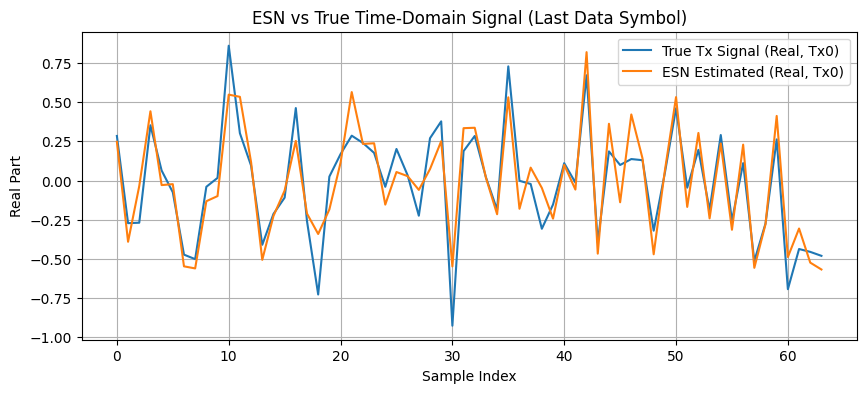

In [110]:
# Initialize NMSE count from previous data symbol
NMSE_count = 1

# Loop over additional data symbols (kk=3 to 6, for example)
for kk in range(3, 10):
    print(f"\n=== Processing data symbol {kk} ===")

    # Data Transmission
    TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
    X = np.zeros((N, N_t)).astype('complex128')
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
    for ii in range(N):
        for iii in range(N_t):
            ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
            X[ii, iii] = Const[ThisQamIdx[0]]
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

    # Nonlinear PA
    x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

    # Reception
    Y_NLD = np.zeros((N, N_r)).astype('complex128')
    y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
            y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_CP_NLD[:, nnn] += noise
    for nnn in range(N_r):
        Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

    # ESN Detection
    ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
    ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
    ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
    ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
    ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
    nForgetPoints = Delay_Min + CyclicPrefixLen
    x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
    x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
    x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N, 3]
    x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
    x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
    x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
    x = x_CP[IsiDuration - 1:, :]
    this_nmse = (
        np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
        np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
    )
    NMSE_ESN_Testing[jj] += this_nmse
    NMSE_count += 1
    X_hat_ESN = np.zeros(X.shape).astype('complex128')
    for ii in range(N_t):
        X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
    ESN_test_input[kk - 1][jj] = ESN_input
    ESN_test_output[kk - 1][jj] = x_hat_ESN

    # Classical Detection
    H_temp = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
    X_hat_Perfect = np.zeros(X.shape).astype('complex128')
    X_hat_LS = np.zeros(X.shape).astype('complex128')
    X_hat_MMSE = np.zeros(X.shape).astype('complex128')
    for ii in range(N):
        Y_temp = np.transpose(Y_NLD[ii, :])
        for nnn in range(N_r):
            for mmm in range(N_t):
                H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
        X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
        X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
        X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

    # Bit Detection
    RxBits_ESN = np.zeros(TxBits.shape)
    RxBits_LS = np.zeros(TxBits.shape)
    RxBits_MMSE = np.zeros(TxBits.shape)
    RxBits_Perfect = np.zeros(TxBits.shape)
    for ii in range(N):
        for iii in range(N_t):
            # Perfect
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_Perfect[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_Perfect[m * ii: m * (ii + 1), iii] = ThisBits
            # ESN
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_ESN[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_ESN[m * ii: m * (ii + 1), iii] = ThisBits
            # LS
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_LS[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_LS[m * ii: m * (ii + 1), iii] = ThisBits
            # MMSE
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_MMSE[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_MMSE[m * ii: m * (ii + 1), iii] = ThisBits

    # Accumulate BER
    bit_errors_ESN = np.sum(TxBits != RxBits_ESN)
    bit_errors_LS = np.sum(TxBits != RxBits_LS)
    bit_errors_MMSE = np.sum(TxBits != RxBits_MMSE)
    bit_errors_Perfect = np.sum(TxBits != RxBits_Perfect)
    TotalBerNum_ESN += bit_errors_ESN
    TotalBerNum_LS += bit_errors_LS
    TotalBerNum_MMSE += bit_errors_MMSE
    TotalBerNum_Perfect += bit_errors_Perfect
    TotalBerDen += NumBitsPerSymbol * N_t

    # Per-symbol print
    print(f"Bit Errors (this symbol) - ESN: {bit_errors_ESN}, LS: {bit_errors_LS}, MMSE: {bit_errors_MMSE}, Perfect: {bit_errors_Perfect}")
    print(f"ESN NMSE (this symbol): {this_nmse}")

# Compute averages (1 pilot, 5 data symbols total so far: kk=2,3,4,5,6)
num_symbols_so_far = 6  # pilot at 1, data at 2-6
num_pilots = 1
BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen
BER_LS[jj] = TotalBerNum_LS / TotalBerDen
BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen
BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen
NMSE_ESN_Training[jj] /= num_pilots
NMSE_ESN_Testing[jj] /= NMSE_count

# Data Flow Check: Final for this SNR segment
print("\n=== Partial Results for SNR {EbNoDB[jj]} dB (after {num_symbols_so_far} symbols) ===")
print(f"BER_ESN: {BER_ESN[jj]:.6f}, BER_LS: {BER_LS[jj]:.6f}, BER_MMSE: {BER_MMSE[jj]:.6f}, BER_Perfect: {BER_Perfect[jj]:.6f}")
print(f"NMSE_ESN_Training: {NMSE_ESN_Training[jj]:.6f}")
print(f"NMSE_ESN_Testing: {NMSE_ESN_Testing[jj]:.6f}")
print(f"Total Bits Processed: {TotalBerDen}")

# Optional Plot: Compare ESN prediction vs true for last symbol, Tx0 real part
plt.figure(figsize=(10, 4))
plt.plot(x[:, 0].real, label='True Tx Signal (Real, Tx0)')
plt.plot(x_hat_ESN[:, 0].real, label='ESN Estimated (Real, Tx0)')
plt.legend()
plt.title('ESN vs True Time-Domain Signal (Last Data Symbol)')
plt.xlabel('Sample Index')
plt.ylabel('Real Part')
plt.grid(True)
plt.show()


=== Processing data symbol 3 ===
Bit Errors (this symbol) - ESN: 83, LS: 45, MMSE: 48, Perfect: 44
ESN NMSE (this symbol): 0.5199138577749273

=== Processing data symbol 4 ===
Bit Errors (this symbol) - ESN: 104, LS: 42, MMSE: 34, Perfect: 39
ESN NMSE (this symbol): 0.5555681988326535

=== Processing data symbol 5 ===
Bit Errors (this symbol) - ESN: 79, LS: 19, MMSE: 26, Perfect: 19
ESN NMSE (this symbol): 0.4869267340105069

=== Processing data symbol 6 ===
Bit Errors (this symbol) - ESN: 78, LS: 38, MMSE: 47, Perfect: 36
ESN NMSE (this symbol): 0.49585626005334127

=== Processing data symbol 7 ===
Bit Errors (this symbol) - ESN: 88, LS: 17, MMSE: 27, Perfect: 19
ESN NMSE (this symbol): 0.5845797151040765

=== Processing data symbol 8 ===
Bit Errors (this symbol) - ESN: 72, LS: 42, MMSE: 44, Perfect: 38
ESN NMSE (this symbol): 0.3923268710001412

=== Processing data symbol 9 ===
Bit Errors (this symbol) - ESN: 85, LS: 30, MMSE: 27, Perfect: 27
ESN NMSE (this symbol): 0.45892028304389

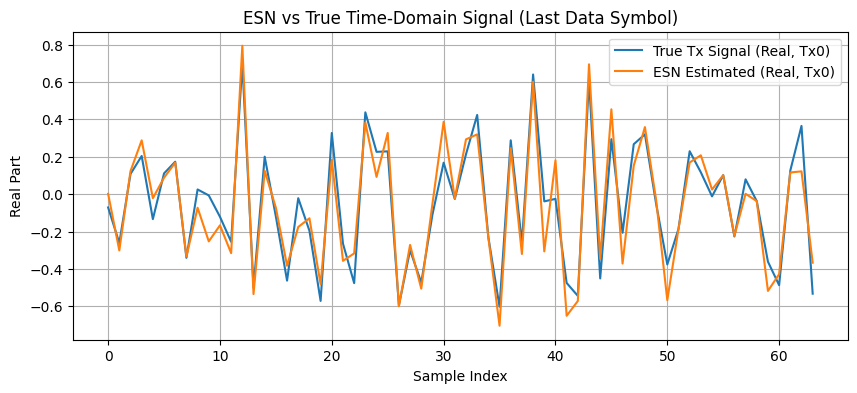

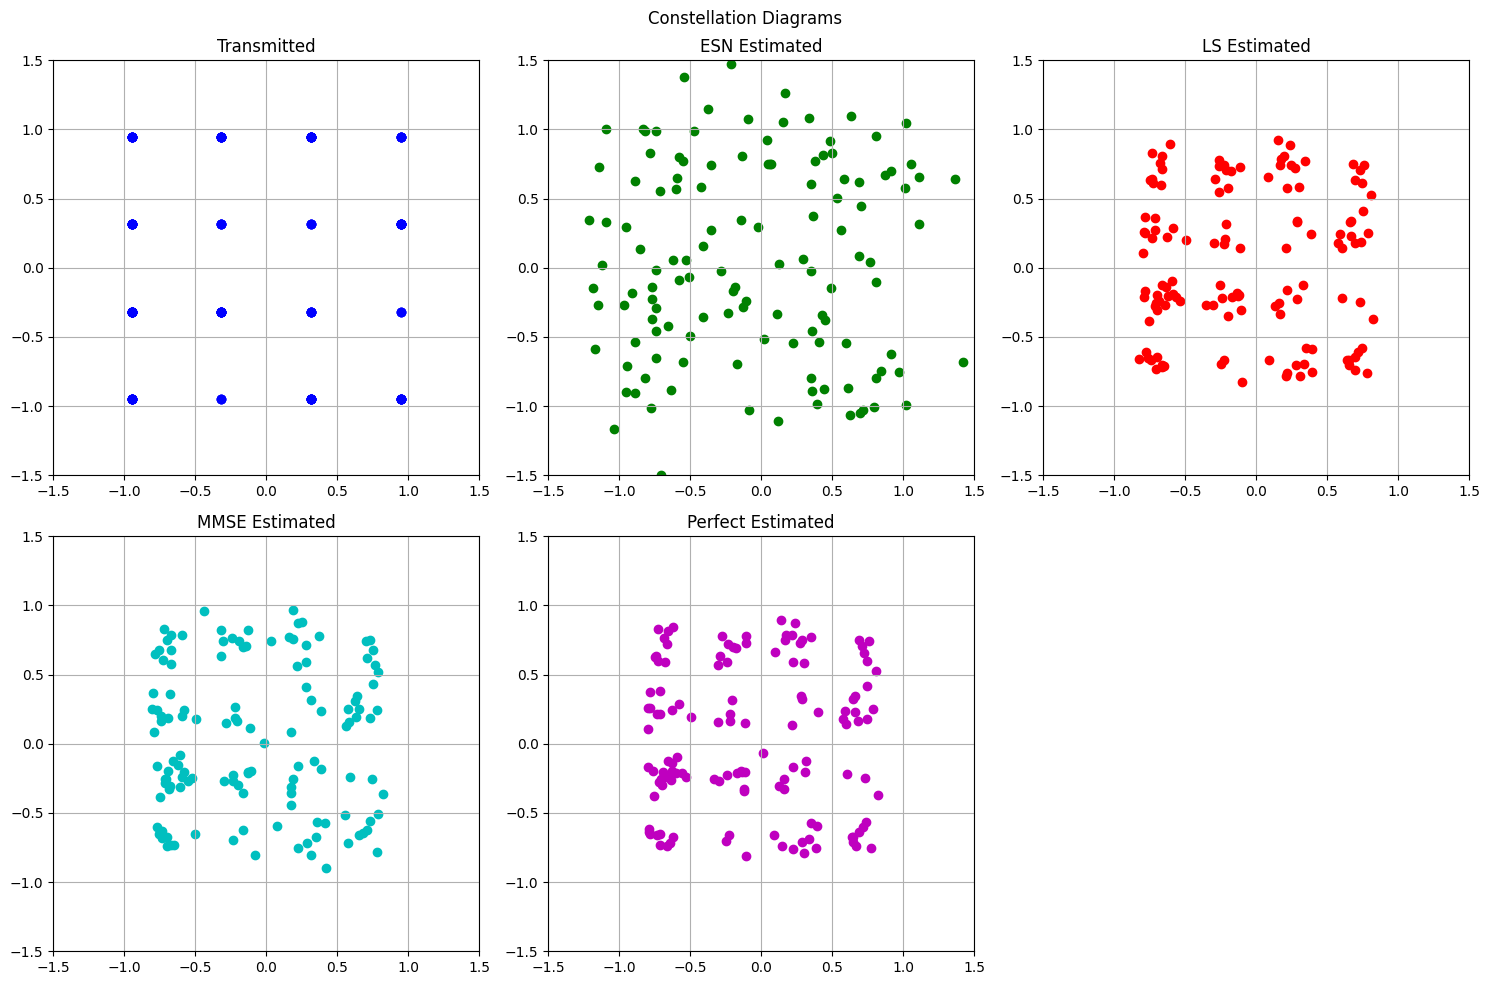

In [112]:
# Initialize NMSE count from previous data symbol
NMSE_count = 1

# Loop over additional data symbols (kk=3 to 6, for example)
for kk in range(3, 100):
    print(f"\n=== Processing data symbol {kk} ===")

    # Data Transmission
    TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
    X = np.zeros((N, N_t)).astype('complex128')
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
    for ii in range(N):
        for iii in range(N_t):
            ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
            X[ii, iii] = Const[ThisQamIdx[0]]
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

    # Nonlinear PA
    x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

    # Reception
    Y_NLD = np.zeros((N, N_r)).astype('complex128')
    y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
            y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_CP_NLD[:, nnn] += noise
    for nnn in range(N_r):
        Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

    # ESN Detection
    ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
    ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
    ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
    ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
    ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
    nForgetPoints = Delay_Min + CyclicPrefixLen
    x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
    x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
    x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N, 3]
    x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
    x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
    x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
    x = x_CP[IsiDuration - 1:, :]
    this_nmse = (
        np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
        np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
    )
    NMSE_ESN_Testing[jj] += this_nmse
    NMSE_count += 1
    X_hat_ESN = np.zeros(X.shape).astype('complex128')
    for ii in range(N_t):
        X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
    ESN_test_input[kk - 1][jj] = ESN_input
    ESN_test_output[kk - 1][jj] = x_hat_ESN

    # Classical Detection
    H_temp = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
    X_hat_Perfect = np.zeros(X.shape).astype('complex128')
    X_hat_LS = np.zeros(X.shape).astype('complex128')
    X_hat_MMSE = np.zeros(X.shape).astype('complex128')
    for ii in range(N):
        Y_temp = np.transpose(Y_NLD[ii, :])
        for nnn in range(N_r):
            for mmm in range(N_t):
                H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
        X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
        X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
        X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

    # Bit Detection
    RxBits_ESN = np.zeros(TxBits.shape)
    RxBits_LS = np.zeros(TxBits.shape)
    RxBits_MMSE = np.zeros(TxBits.shape)
    RxBits_Perfect = np.zeros(TxBits.shape)
    for ii in range(N):
        for iii in range(N_t):
            # Perfect
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_Perfect[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_Perfect[m * ii: m * (ii + 1), iii] = ThisBits
            # ESN
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_ESN[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_ESN[m * ii: m * (ii + 1), iii] = ThisBits
            # LS
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_LS[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_LS[m * ii: m * (ii + 1), iii] = ThisBits
            # MMSE
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_MMSE[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_MMSE[m * ii: m * (ii + 1), iii] = ThisBits

    # Accumulate BER
    bit_errors_ESN = np.sum(TxBits != RxBits_ESN)
    bit_errors_LS = np.sum(TxBits != RxBits_LS)
    bit_errors_MMSE = np.sum(TxBits != RxBits_MMSE)
    bit_errors_Perfect = np.sum(TxBits != RxBits_Perfect)
    TotalBerNum_ESN += bit_errors_ESN
    TotalBerNum_LS += bit_errors_LS
    TotalBerNum_MMSE += bit_errors_MMSE
    TotalBerNum_Perfect += bit_errors_Perfect
    TotalBerDen += NumBitsPerSymbol * N_t

    # Per-symbol print
    print(f"Bit Errors (this symbol) - ESN: {bit_errors_ESN}, LS: {bit_errors_LS}, MMSE: {bit_errors_MMSE}, Perfect: {bit_errors_Perfect}")
    print(f"ESN NMSE (this symbol): {this_nmse}")

# Compute averages (1 pilot, 5 data symbols total so far: kk=2,3,4,5,6)
num_symbols_so_far = 6  # pilot at 1, data at 2-6
num_pilots = 1
BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen
BER_LS[jj] = TotalBerNum_LS / TotalBerDen
BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen
BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen
NMSE_ESN_Training[jj] /= num_pilots
NMSE_ESN_Testing[jj] /= NMSE_count

# Data Flow Check: Final for this SNR segment
print("\n=== Partial Results for SNR {EbNoDB[jj]} dB (after {num_symbols_so_far} symbols) ===")
print(f"BER_ESN: {BER_ESN[jj]:.6f}, BER_LS: {BER_LS[jj]:.6f}, BER_MMSE: {BER_MMSE[jj]:.6f}, BER_Perfect: {BER_Perfect[jj]:.6f}")
print(f"NMSE_ESN_Training: {NMSE_ESN_Training[jj]:.6f}")
print(f"NMSE_ESN_Testing: {NMSE_ESN_Testing[jj]:.6f}")
print(f"Total Bits Processed: {TotalBerDen}")

# Optional Plot: Compare ESN prediction vs true for last symbol, Tx0 real part
plt.figure(figsize=(10, 4))
plt.plot(x[:, 0].real, label='True Tx Signal (Real, Tx0)')
plt.plot(x_hat_ESN[:, 0].real, label='ESN Estimated (Real, Tx0)')
plt.legend()
plt.title('ESN vs True Time-Domain Signal (Last Data Symbol)')
plt.xlabel('Sample Index')
plt.ylabel('Real Part')
plt.grid(True)
plt.show()

# Constellation Diagrams
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Constellation Diagrams')

# Transmitted
axs[0, 0].scatter(X.real.ravel(), X.imag.ravel(), color='b')
axs[0, 0].set_title('Transmitted')
axs[0, 0].grid(True)
axs[0, 0].set_xlim([-1.5, 1.5])
axs[0, 0].set_ylim([-1.5, 1.5])

# ESN
axs[0, 1].scatter(X_hat_ESN.real.ravel(), X_hat_ESN.imag.ravel(), color='g')
axs[0, 1].set_title('ESN Estimated')
axs[0, 1].grid(True)
axs[0, 1].set_xlim([-1.5, 1.5])
axs[0, 1].set_ylim([-1.5, 1.5])

# LS
axs[0, 2].scatter(X_hat_LS.real.ravel(), X_hat_LS.imag.ravel(), color='r')
axs[0, 2].set_title('LS Estimated')
axs[0, 2].grid(True)
axs[0, 2].set_xlim([-1.5, 1.5])
axs[0, 2].set_ylim([-1.5, 1.5])

# MMSE
axs[1, 0].scatter(X_hat_MMSE.real.ravel(), X_hat_MMSE.imag.ravel(), color='c')
axs[1, 0].set_title('MMSE Estimated')
axs[1, 0].grid(True)
axs[1, 0].set_xlim([-1.5, 1.5])
axs[1, 0].set_ylim([-1.5, 1.5])

# Perfect
axs[1, 1].scatter(X_hat_Perfect.real.ravel(), X_hat_Perfect.imag.ravel(), color='m')
axs[1, 1].set_title('Perfect Estimated')
axs[1, 1].grid(True)
axs[1, 1].set_xlim([-1.5, 1.5])
axs[1, 1].set_ylim([-1.5, 1.5])

# Hide empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


=== Processing data symbol 3 ===
Bit Errors (this symbol) - ESN: 77, LS: 49, MMSE: 48, Perfect: 47
ESN NMSE (this symbol): 0.44138066738424486

=== Processing data symbol 4 ===
Bit Errors (this symbol) - ESN: 102, LS: 37, MMSE: 47, Perfect: 37
ESN NMSE (this symbol): 0.604211506171805

=== Processing data symbol 5 ===
Bit Errors (this symbol) - ESN: 80, LS: 17, MMSE: 30, Perfect: 15
ESN NMSE (this symbol): 0.5834502008590925

=== Processing data symbol 6 ===
Bit Errors (this symbol) - ESN: 73, LS: 15, MMSE: 25, Perfect: 16
ESN NMSE (this symbol): 0.39165415770971246

=== Processing data symbol 7 ===
Bit Errors (this symbol) - ESN: 79, LS: 14, MMSE: 25, Perfect: 16
ESN NMSE (this symbol): 0.49731800961471284

=== Processing data symbol 8 ===
Bit Errors (this symbol) - ESN: 96, LS: 33, MMSE: 45, Perfect: 39
ESN NMSE (this symbol): 0.6346551236211735

=== Processing data symbol 9 ===
Bit Errors (this symbol) - ESN: 71, LS: 26, MMSE: 37, Perfect: 28
ESN NMSE (this symbol): 0.4385127568040

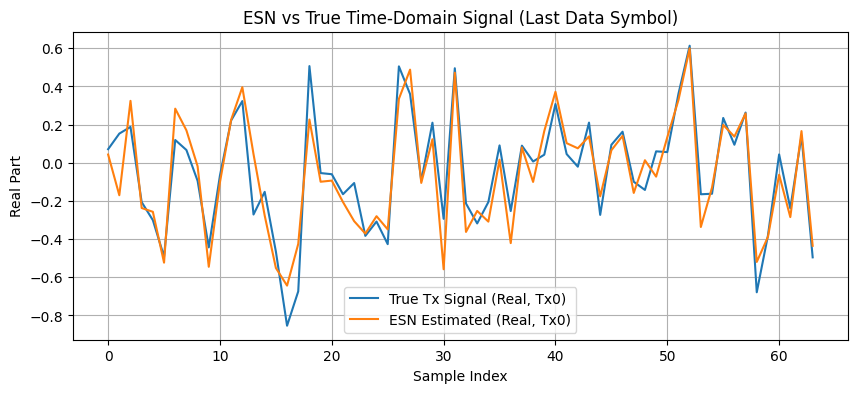

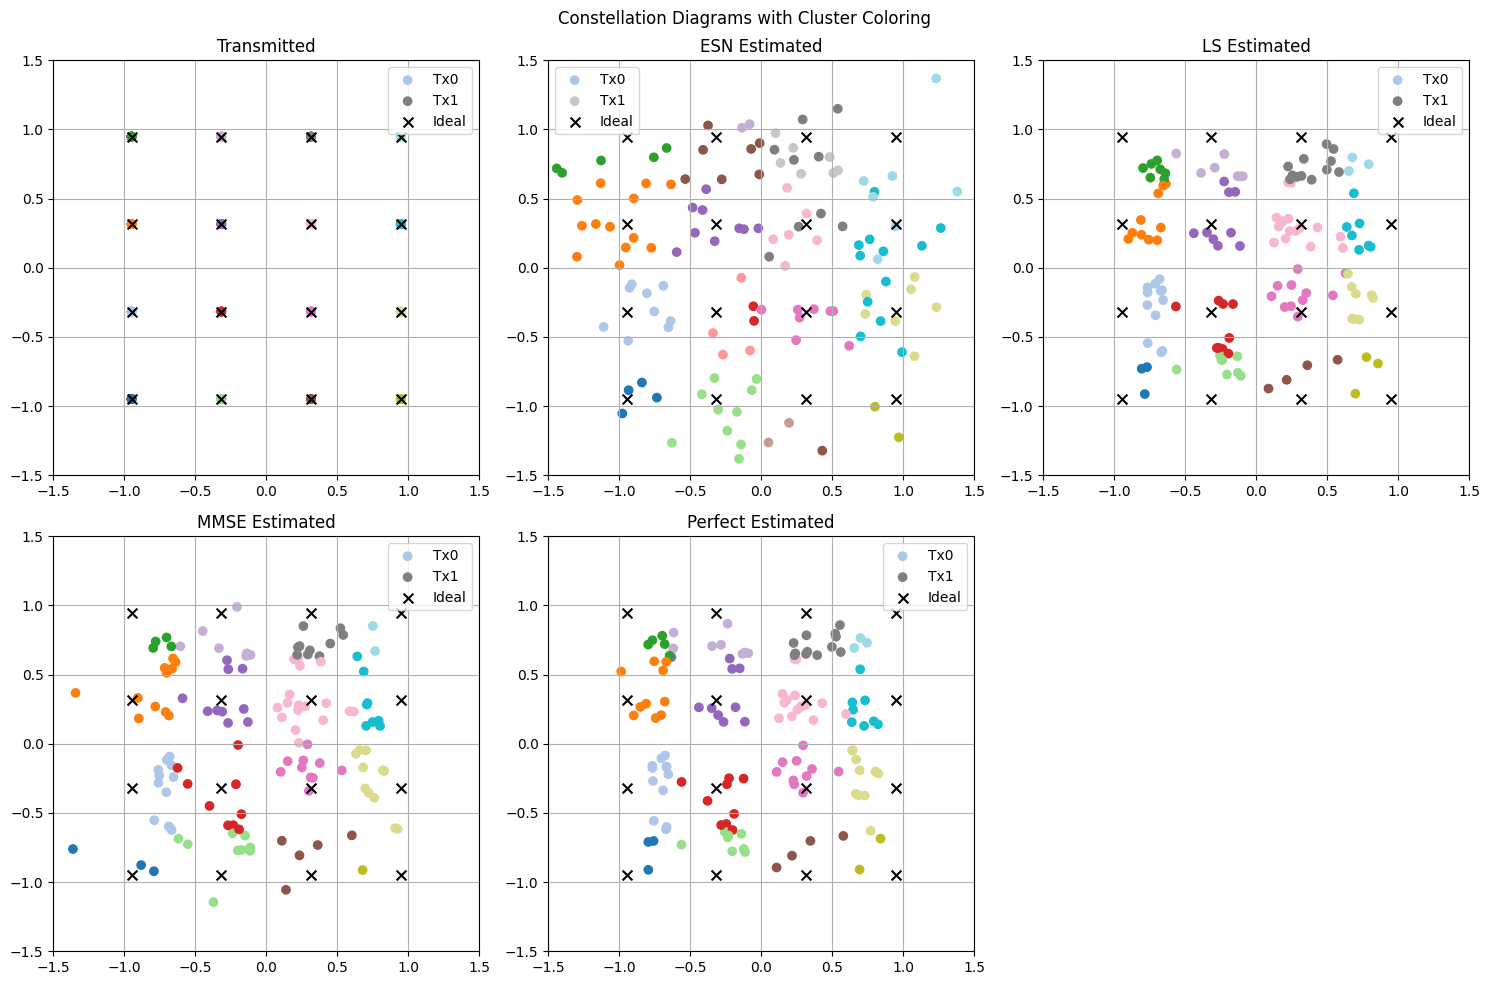

In [ ]:
# Initialize NMSE count from previous data symbol
NMSE_count = 1

# Loop over additional data symbols (kk=3 to 6, for example)
for kk in range(3, 30):
    print(f"\n=== Processing data symbol {kk} ===")

    # Data Transmission
    TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
    X = np.zeros((N, N_t)).astype('complex128')
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
    for ii in range(N):
        for iii in range(N_t):
            ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
            X[ii, iii] = Const[ThisQamIdx[0]]
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

    # Nonlinear PA
    x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

    # Reception
    Y_NLD = np.zeros((N, N_r)).astype('complex128')
    y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
            y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_CP_NLD[:, nnn] += noise
    for nnn in range(N_r):
        Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

    # ESN Detection
    ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
    ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
    ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
    ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
    ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
    nForgetPoints = Delay_Min + CyclicPrefixLen
    x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
    x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
    x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N, 3]
    x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
    x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
    x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
    x = x_CP[IsiDuration - 1:, :]
    this_nmse = (
        np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
        np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
    )
    NMSE_ESN_Testing[jj] += this_nmse
    NMSE_count += 1
    X_hat_ESN = np.zeros(X.shape).astype('complex128')
    for ii in range(N_t):
        X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / math.sqrt(Pi[jj])
    ESN_test_input[kk - 1][jj] = ESN_input
    ESN_test_output[kk - 1][jj] = x_hat_ESN

    # Classical Detection
    H_temp = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
    H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
    X_hat_Perfect = np.zeros(X.shape).astype('complex128')
    X_hat_LS = np.zeros(X.shape).astype('complex128')
    X_hat_MMSE = np.zeros(X.shape).astype('complex128')
    for ii in range(N):
        Y_temp = np.transpose(Y_NLD[ii, :])
        for nnn in range(N_r):
            for mmm in range(N_t):
                H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
        X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / math.sqrt(Pi[jj])
        X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / math.sqrt(Pi[jj])
        X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / math.sqrt(Pi[jj])

    # Bit Detection
    RxBits_ESN = np.zeros(TxBits.shape)
    RxBits_LS = np.zeros(TxBits.shape)
    RxBits_MMSE = np.zeros(TxBits.shape)
    RxBits_Perfect = np.zeros(TxBits.shape)
    for ii in range(N):
        for iii in range(N_t):
            # Perfect
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_Perfect[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_Perfect[m * ii: m * (ii + 1), iii] = ThisBits
            # ESN
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_ESN[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_ESN[m * ii: m * (ii + 1), iii] = ThisBits
            # LS
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_LS[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_LS[m * ii: m * (ii + 1), iii] = ThisBits
            # MMSE
            ThisQamIdx = np.argmin(np.absolute(Const - X_hat_MMSE[ii, iii]))
            ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
            ThisBits = np.array([int(i) for i in ThisBits])[::-1]
            RxBits_MMSE[m * ii: m * (ii + 1), iii] = ThisBits

    # Accumulate BER
    bit_errors_ESN = np.sum(TxBits != RxBits_ESN)
    bit_errors_LS = np.sum(TxBits != RxBits_LS)
    bit_errors_MMSE = np.sum(TxBits != RxBits_MMSE)
    bit_errors_Perfect = np.sum(TxBits != RxBits_Perfect)
    TotalBerNum_ESN += bit_errors_ESN
    TotalBerNum_LS += bit_errors_LS
    TotalBerNum_MMSE += bit_errors_MMSE
    TotalBerNum_Perfect += bit_errors_Perfect
    TotalBerDen += NumBitsPerSymbol * N_t

    # Per-symbol print
    print(f"Bit Errors (this symbol) - ESN: {bit_errors_ESN}, LS: {bit_errors_LS}, MMSE: {bit_errors_MMSE}, Perfect: {bit_errors_Perfect}")
    print(f"ESN NMSE (this symbol): {this_nmse}")

# Compute averages (1 pilot, 5 data symbols total so far: kk=2,3,4,5,6)
num_symbols_so_far = 6  # pilot at 1, data at 2-6
num_pilots = 1
BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen
BER_LS[jj] = TotalBerNum_LS / TotalBerDen
BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen
BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen
NMSE_ESN_Training[jj] /= num_pilots
NMSE_ESN_Testing[jj] /= NMSE_count

# Data Flow Check: Final for this SNR segment
print("\n=== Partial Results for SNR {EbNoDB[jj]} dB (after {num_symbols_so_far} symbols) ===")
print(f"BER_ESN: {BER_ESN[jj]:.6f}, BER_LS: {BER_LS[jj]:.6f}, BER_MMSE: {BER_MMSE[jj]:.6f}, BER_Perfect: {BER_Perfect[jj]:.6f}")
print(f"NMSE_ESN_Training: {NMSE_ESN_Training[jj]:.6f}")
print(f"NMSE_ESN_Testing: {NMSE_ESN_Testing[jj]:.6f}")
print(f"Total Bits Processed: {TotalBerDen}")

# Optional Plot: Compare ESN prediction vs true for last symbol, Tx0 real part
plt.figure(figsize=(10, 4))
plt.plot(x[:, 0].real, label='True Tx Signal (Real, Tx0)')
plt.plot(x_hat_ESN[:, 0].real, label='ESN Estimated (Real, Tx0)')
plt.legend()
plt.title('ESN vs True Time-Domain Signal (Last Data Symbol)')
plt.xlabel('Sample Index')
plt.ylabel('Real Part')
plt.grid(True)
plt.show()

# Function to get cluster labels
def get_cluster_labels(symbols, const):
    labels = np.zeros(len(symbols), dtype=int)
    for i, sym in enumerate(symbols):
        labels[i] = np.argmin(np.abs(const - sym))
    return labels

# Constellation Diagrams
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Constellation Diagrams with Cluster Coloring')

# Ideal constellation points for reference
ideal_real = Const.real
ideal_imag = Const.imag

# Transmitted
labels_tx0 = get_cluster_labels(X[:, 0], Const)
labels_tx1 = get_cluster_labels(X[:, 1], Const)
axs[0, 0].scatter(X[:, 0].real, X[:, 0].imag, c=labels_tx0, cmap='tab20', label='Tx0')
axs[0, 0].scatter(X[:, 1].real, X[:, 1].imag, c=labels_tx1, cmap='tab20', label='Tx1')
axs[0, 0].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[0, 0].set_title('Transmitted')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_xlim([-1.5, 1.5])
axs[0, 0].set_ylim([-1.5, 1.5])

# ESN
labels_esn0 = get_cluster_labels(X_hat_ESN[:, 0], Const)
labels_esn1 = get_cluster_labels(X_hat_ESN[:, 1], Const)
axs[0, 1].scatter(X_hat_ESN[:, 0].real, X_hat_ESN[:, 0].imag, c=labels_esn0, cmap='tab20', label='Tx0')
axs[0, 1].scatter(X_hat_ESN[:, 1].real, X_hat_ESN[:, 1].imag, c=labels_esn1, cmap='tab20', label='Tx1')
axs[0, 1].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[0, 1].set_title('ESN Estimated')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_xlim([-1.5, 1.5])
axs[0, 1].set_ylim([-1.5, 1.5])

# LS
labels_ls0 = get_cluster_labels(X_hat_LS[:, 0], Const)
labels_ls1 = get_cluster_labels(X_hat_LS[:, 1], Const)
axs[0, 2].scatter(X_hat_LS[:, 0].real, X_hat_LS[:, 0].imag, c=labels_ls0, cmap='tab20', label='Tx0')
axs[0, 2].scatter(X_hat_LS[:, 1].real, X_hat_LS[:, 1].imag, c=labels_ls1, cmap='tab20', label='Tx1')
axs[0, 2].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[0, 2].set_title('LS Estimated')
axs[0, 2].legend()
axs[0, 2].grid(True)
axs[0, 2].set_xlim([-1.5, 1.5])
axs[0, 2].set_ylim([-1.5, 1.5])

# MMSE
labels_mmse0 = get_cluster_labels(X_hat_MMSE[:, 0], Const)
labels_mmse1 = get_cluster_labels(X_hat_MMSE[:, 1], Const)
axs[1, 0].scatter(X_hat_MMSE[:, 0].real, X_hat_MMSE[:, 0].imag, c=labels_mmse0, cmap='tab20', label='Tx0')
axs[1, 0].scatter(X_hat_MMSE[:, 1].real, X_hat_MMSE[:, 1].imag, c=labels_mmse1, cmap='tab20', label='Tx1')
axs[1, 0].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[1, 0].set_title('MMSE Estimated')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_xlim([-1.5, 1.5])
axs[1, 0].set_ylim([-1.5, 1.5])

# Perfect
labels_perfect0 = get_cluster_labels(X_hat_Perfect[:, 0], Const)
labels_perfect1 = get_cluster_labels(X_hat_Perfect[:, 1], Const)
axs[1, 1].scatter(X_hat_Perfect[:, 0].real, X_hat_Perfect[:, 0].imag, c=labels_perfect0, cmap='tab20', label='Tx0')
axs[1, 1].scatter(X_hat_Perfect[:, 1].real, X_hat_Perfect[:, 1].imag, c=labels_perfect1, cmap='tab20', label='Tx1')
axs[1, 1].scatter(ideal_real, ideal_imag, color='black', marker='x', s=50, label='Ideal')
axs[1, 1].set_title('Perfect Estimated')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_xlim([-1.5, 1.5])
axs[1, 1].set_ylim([-1.5, 1.5])

# Hide empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# esn.py

import numpy as np

def identity(x):
    return x

def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s

class ESN:
    def __init__(self, n_inputs, n_outputs, n_reservoir=1000, spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None, teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity, random_state=None, silent=True):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)
        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift
        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            self.random_state_ = np.random.RandomState(random_state)
        else:
            self.random_state_ = np.random.mtrand._rand
        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
        self.W_in = self.random_state_.rand(self.n_reservoir, self.n_inputs) * 2 - 1
        self.W_feedb = self.random_state_.rand(self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern) + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        return np.tanh(preactivation) + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5)

    def _scale_inputs(self, inputs):
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, nForgetPoints=0, inspect=False):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :], teachers_scaled[n - 1, :])
        transient = max(0, nForgetPoints)
        extended_states = np.hstack((states, inputs_scaled))
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]), self.inverse_out_activation(teachers_scaled[transient:, :])).T
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
        pred_train = self._unscale_teacher(self.out_activation(np.dot(extended_states, self.W_out.T)))
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]
        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)
        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack([laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack([lastoutput, np.zeros((n_samples, self.n_outputs))])
        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out, np.concatenate([states[n + 1, :], inputs[n + 1, :]])))
        return self._unscale_teacher(self.out_activation(outputs[1:]))

class DeepESN:
    def __init__(self, n_layers, n_inputs, n_outputs, n_reservoir=700, spectral_radius=0.95, sparsity=0, noise=0.001,
                 input_shift=None, input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None, out_activation=identity,
                 inverse_out_activation=identity, random_state=None, silent=True):
        self.n_layers = n_layers
        self.layers = []
        current_n_inputs = n_inputs
        for l in range(n_layers):
            layer = ESN(current_n_inputs, n_outputs, n_reservoir, spectral_radius, sparsity, noise, input_shift,
                        input_scaling, teacher_forcing, feedback_scaling, teacher_scaling, teacher_shift,
                        out_activation, inverse_out_activation, random_state, silent)
            self.layers.append(layer)
            current_n_inputs = n_outputs  # Next input dim = output dim of previous

    def fit(self, inputs, outputs, nForgetPoints=0):
        current_input = inputs
        for layer in self.layers:
            layer.fit(current_input, outputs, nForgetPoints)  # Each fits to same target
            current_input = layer.predict(current_input)  # Update input for next layer

    def predict(self, inputs, continuation=True):
        current_input = inputs
        for layer in self.layers:
            current_input = layer.predict(current_input, continuation)
        return current_input


=== Processing SNR: EbNoDB = 25 dB ===

=== Processing data symbol 1 ===
Bit Errors (this symbol) - ESN: 130, DeepESN: 115, LS: 28, MMSE: 239, Perfect: 25
ESN NMSE (this symbol): 1.3641742029903021
DeepESN NMSE (this symbol): 1.0481194785267989

=== Processing data symbol 2 ===
Bit Errors (this symbol) - ESN: 117, DeepESN: 134, LS: 28, MMSE: 241, Perfect: 32
ESN NMSE (this symbol): 0.8961638003662034
DeepESN NMSE (this symbol): 1.013404279146201

=== Processing data symbol 3 ===
Bit Errors (this symbol) - ESN: 127, DeepESN: 132, LS: 27, MMSE: 267, Perfect: 27
ESN NMSE (this symbol): 1.1389905679369627
DeepESN NMSE (this symbol): 0.9330253162999024

=== Processing data symbol 4 ===
Bit Errors (this symbol) - ESN: 128, DeepESN: 135, LS: 39, MMSE: 215, Perfect: 41
ESN NMSE (this symbol): 1.1873516610336161
DeepESN NMSE (this symbol): 0.9977931119584811

=== Processing data symbol 5 ===
Bit Errors (this symbol) - ESN: 109, DeepESN: 119, LS: 25, MMSE: 250, Perfect: 24
ESN NMSE (this symbol

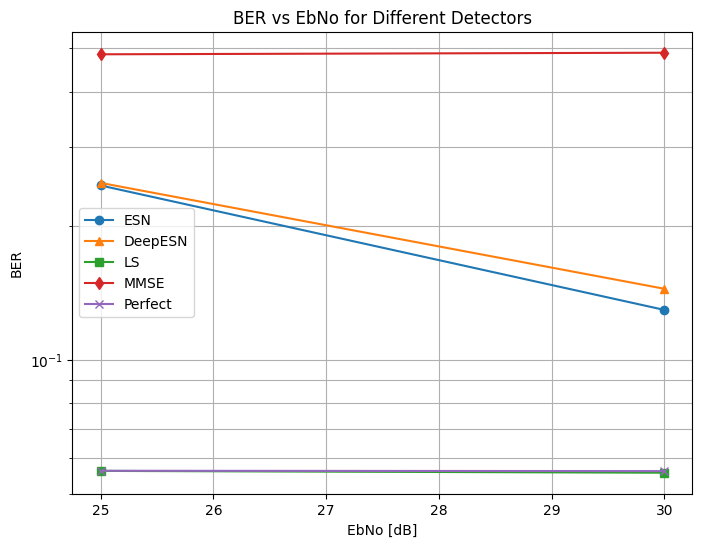

In [13]:
# main.py (updated for comparison between ESN and DeepESN)

import time
import numpy as np
import math
from scipy import interpolate
import matplotlib.pyplot as plt
import tensorflow as tf
from sionna.channel import cir_to_time_channel




# To compare ESN (shallow) and DeepESN, we'll run the detection twice per data symbol: once with each model.
# Train both on pilot, then detect/compare per symbol.

# Initialize Arrays (duplicate for deep)
ESN_train_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_train_teacher = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_input = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
ESN_test_output = [[None] * len(EbNoDB) for _ in range(NumOfdmSymbols)]
BER_ESN = np.zeros(len(EbNoDB))
BER_Perfect = np.zeros(len(EbNoDB))
BER_LS = np.zeros(len(EbNoDB))
BER_MMSE = np.zeros(len(EbNoDB))
NMSE_ESN_Testing = np.zeros(len(EbNoDB))
NMSE_ESN_Training = np.zeros(len(EbNoDB))
c = [[None] * N_t for _ in range(N_r)]
Ci = [[None] * N_t for _ in range(N_r)]
Ci_LS = [[None] * N_t for _ in range(N_r)]
Ci_MMSE = [[None] * N_t for _ in range(N_r)]
Ci_LS_Pilots = [[None] * N_t for _ in range(N_r)]

# For DeepESN
BER_DeepESN = np.zeros(len(EbNoDB))
NMSE_DeepESN_Testing = np.zeros(len(EbNoDB))
NMSE_DeepESN_Training = np.zeros(len(EbNoDB))
BLER_DeepESN = np.zeros(len(EbNoDB))

num_snrs = len(EbNoDB)
Pi = np.zeros(num_snrs)
MMSEScaler = np.zeros(num_snrs)
BER_ESN = np.zeros(num_snrs)
BER_LS = np.zeros(num_snrs)
BER_MMSE = np.zeros(num_snrs)
BER_Perfect = np.zeros(num_snrs)
BLER_ESN = np.zeros(num_snrs)
BLER_LS = np.zeros(num_snrs)
BLER_MMSE = np.zeros(num_snrs)
BLER_Perfect = np.zeros(num_snrs)
NMSE_ESN_Testing = np.zeros(num_snrs)
NMSE_ESN_Training = np.zeros(num_snrs)
runtimes = np.zeros(num_snrs)

max_blocks = 10000  # Max data symbols per SNR
min_block_errors = 100  # Target for early stop per method

NumBitsPerSymbol = m * N

DEEP_LAYERS = 3  

for jj in range(num_snrs):
    print(f"\n=== Processing SNR: EbNoDB = {EbNoDB[jj]} dB ===")
    start_time = time.time()

    # SNR-specific params
    var_x = np.power(10, (EbNoDB[jj] / 10)) * No * N
    Ptotal = var_x
    Pi[jj] = Ptotal / N
    A_Clip = np.sqrt(var_x) * np.float_power(10, ClipLeveldB / 20)
    inputScaling = inputScaler / (var_x ** 0.5) * np.ones(N_t * 2)
    inputShift = inputOffset / inputScaler * np.ones(N_t * 2)
    MMSEScaler[jj] = No / Pi[jj]
    MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj] / (N / 2) * np.eye(IsiDuration))

    # Pilot symbol (kk=1)
    # Channel Generation using Sionna CDL
    batch_size = 1
    num_time_samples = 1
    a, tau = cdl(batch_size, num_time_samples, W)
    a = a.numpy()
    tau = tau.numpy()
    h_time = cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
    h_time = h_time.numpy()

    # Store channel
    for nnn in range(N_r):
        for mmm in range(N_t):
            c[nnn][mmm] = h_time[0, 0, nnn, 0, mmm, 0, :]
            Ci[nnn][mmm] = np.fft.fft(np.append(c[nnn][mmm], np.zeros(N - IsiDuration)))

    # Pilot Transmission
    TxBits = (np.random.uniform(0, 1, size=(N * m_pilot, N_t)) > 0.5).astype(np.int32)
    X = np.zeros((N, N_t)).astype('complex128')
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
    for ii in range(N):
        for iii in range(N_t):
            ThisQamIdx = np.matmul(PowersOfTwo[0, :m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot), iii])
            X[ii, iii] = ConstPilot[ThisQamIdx]
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

    # Nonlinear PA
    x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

    # Channel and Noise
    y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
            y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_CP_NLD[:, nnn] += noise
    Y = np.zeros((N, N_r)).astype('complex128')
    for nnn in range(N_r):
        Y[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

    # Orthogonal Pilots for LS
    X_LS = X.copy()
    X_LS[np.arange(1, len(X_LS), 2), 0] = 0
    X_LS[np.arange(0, len(X_LS), 2), 1] = 0
    x_LS_CP = np.zeros(x_CP.shape).astype('complex128')
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X_LS[:, iii])
        x_LS_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_LS_CP[:, iii] = x_LS_CP[:, iii] * (Pi[jj] ** 0.5)
    y_LS_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_LS_CP[:, mmm], h_cdl, mode='full')
            y_LS_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_LS_CP[:, nnn] += noise
    Y_LS = np.zeros((N, N_r)).astype('complex128')
    for nnn in range(N_r):
        Y_LS[:, nnn] = 1 / N * np.fft.fft(y_LS_CP[IsiDuration - 1:, nnn])
    Y_LS = Y_LS / (Pi[jj] ** 0.5)

    # LS and MMSE Channel Estimation
    for nnn in range(N_r):
        for mmm in range(N_t):
            Ci_LS_Pilots[nnn][mmm] = Y_LS[np.arange(mmm, len(Y_LS), 2), nnn] / X_LS[np.arange(mmm, len(X_LS), 2), mmm]
            c_LS = np.fft.ifft(Ci_LS_Pilots[nnn][mmm])[:IsiDuration]
            c_MMSE = np.matmul(MMSE_bold_TD, c_LS)
            Ci_MMSE[nnn][mmm] = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))
            interp_x = np.arange(mmm, N, N_t)
            interp_y = Ci_LS_Pilots[nnn][mmm]
            if mmm == 0:
                interp_x = np.append(interp_x, N - 1)
                interp_y = np.append(interp_y, interp_y[-1])
            else:
                interp_x = np.append(0, interp_x)
                interp_y = np.append(interp_y[0], interp_y)
            tmpf = interpolate.interp1d(interp_x, interp_y)
            Ci_LS[nnn][mmm] = tmpf(np.arange(N))

    # ESN Training (Shallow)
    esn_shallow = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
                      sparsity=1 - min(0.2 * nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling,
                      teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
    [ESN_input, ESN_output, trainedEsn_shallow, Delay_shallow, Delay_Idx_shallow, Delay_Min_shallow, Delay_Max_shallow, nForgetPoints_shallow, NMSE_ESN_shallow] = \
        HelpFunc.trainMIMOESN(esn_shallow, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP_NLD, x_CP)
    NMSE_ESN_Training[jj] = NMSE_ESN_shallow

    # DeepESN Training
    esn_deep = DeepESN(DEEP_LAYERS, n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
                       sparsity=1 - min(0.2 * nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling,
                       teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
    [ESN_input_deep, ESN_output_deep, trainedEsn_deep, Delay_deep, Delay_Idx_deep, Delay_Min_deep, Delay_Max_deep, nForgetPoints_deep, NMSE_ESN_deep] = \
        HelpFunc.trainMIMOESN(esn_deep, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP_NLD, x_CP)
    NMSE_DeepESN_Training[jj] = NMSE_ESN_deep

    # Reset accumulators for this SNR (duplicate for deep)
    TotalBerNum_ESN = 0
    TotalBerNum_DeepESN = 0
    TotalBerNum_LS = 0
    TotalBerNum_MMSE = 0
    TotalBerNum_Perfect = 0
    TotalBerDen = 0
    block_errors_ESN = 0
    block_errors_DeepESN = 0
    block_errors_LS = 0
    block_errors_MMSE = 0
    block_errors_Perfect = 0
    num_blocks = 0
    NMSE_ESN_Testing[jj] = 0
    NMSE_DeepESN_Testing[jj] = 0
    NMSE_count = 0

    while num_blocks < max_blocks and max(block_errors_ESN, block_errors_DeepESN, block_errors_LS, block_errors_MMSE, block_errors_Perfect) < min_block_errors:
        num_blocks += 1
        # Data symbol processing
        TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
        X = np.zeros((N, N_t)).astype('complex128')
        x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
        for ii in range(N):
            for iii in range(N_t):
                ThisQamIdx = np.matmul(PowersOfTwo[0, :m], TxBits[m * ii + np.arange(m), iii])
                X[ii, iii] = Const[ThisQamIdx]
        for iii in range(N_t):
            x_temp = N * np.fft.ifft(X[:, iii])
            x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
            x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

        # Nonlinear PA
        x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

        # Reception
        Y_NLD = np.zeros((N, N_r)).astype('complex128')
        y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
        for nnn in range(N_r):
            for mmm in range(N_t):
                h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
                conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
                y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
            noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
            y_CP_NLD[:, nnn] += noise
        for nnn in range(N_r):
            Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

        # ESN Detection (Shallow)
        ESN_input = np.zeros((N + Delay_Max_shallow + CyclicPrefixLen, N_t * 2))
        ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max_shallow))
        ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max_shallow))
        ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max_shallow))
        ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max_shallow))
        nForgetPoints = Delay_Min_shallow + CyclicPrefixLen
        x_hat_ESN_temp = trainedEsn_shallow.predict(ESN_input, continuation=False)[nForgetPoints:, :]
        x_hat_ESN_0 = x_hat_ESN_temp[Delay_shallow[0] - Delay_Min_shallow: Delay_shallow[0] - Delay_Min_shallow + N, 0] + 1j * x_hat_ESN_temp[Delay_shallow[1] - Delay_Min_shallow: Delay_shallow[1] - Delay_Min_shallow + N, 1]
        x_hat_ESN_1 = x_hat_ESN_temp[Delay_shallow[2] - Delay_Min_shallow: Delay_shallow[2] - Delay_Min_shallow + N, 2] + 1j * x_hat_ESN_temp[Delay_shallow[3] - Delay_Min_shallow: Delay_shallow[3] - Delay_Min_shallow + N, 3]
        x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
        x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
        x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
        x = x_CP[IsiDuration - 1:, :]
        this_nmse_esn = (
            np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
            np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
        )
        X_hat_ESN = np.zeros(X.shape).astype('complex128')
        for ii in range(N_t):
            X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / np.sqrt(Pi[jj])

        # DeepESN Detection
        ESN_input_deep = np.zeros((N + Delay_Max_deep + CyclicPrefixLen, N_t * 2))
        ESN_input_deep[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max_deep))
        ESN_input_deep[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max_deep))
        ESN_input_deep[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max_deep))
        ESN_input_deep[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max_deep))
        nForgetPoints_deep = Delay_Min_deep + CyclicPrefixLen
        x_hat_DeepESN_temp = trainedEsn_deep.predict(ESN_input_deep, continuation=False)[nForgetPoints_deep:, :]
        x_hat_DeepESN_0 = x_hat_DeepESN_temp[Delay_deep[0] - Delay_Min_deep: Delay_deep[0] - Delay_Min_deep + N, 0] + 1j * x_hat_DeepESN_temp[Delay_deep[1] - Delay_Min_deep: Delay_deep[1] - Delay_Min_deep + N, 1]
        x_hat_DeepESN_1 = x_hat_DeepESN_temp[Delay_deep[2] - Delay_Min_deep: Delay_deep[2] - Delay_Min_deep + N, 2] + 1j * x_hat_DeepESN_temp[Delay_deep[3] - Delay_Min_deep: Delay_deep[3] - Delay_Min_deep + N, 3]
        x_hat_DeepESN_0 = x_hat_DeepESN_0.reshape(-1, 1)
        x_hat_DeepESN_1 = x_hat_DeepESN_1.reshape(-1, 1)
        x_hat_DeepESN = np.hstack((x_hat_DeepESN_0, x_hat_DeepESN_1))
        this_nmse_deep = (
            np.linalg.norm(x_hat_DeepESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
            np.linalg.norm(x_hat_DeepESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
        )
        X_hat_DeepESN = np.zeros(X.shape).astype('complex128')
        for ii in range(N_t):
            X_hat_DeepESN[:, ii] = 1 / N * np.fft.fft(x_hat_DeepESN[:, ii]) / np.sqrt(Pi[jj])

        # Classical Detection (same for both)
        H_temp = np.zeros((N_r, N_t)).astype('complex128')
        H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
        H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
        X_hat_Perfect = np.zeros(X.shape).astype('complex128')
        X_hat_LS = np.zeros(X.shape).astype('complex128')
        X_hat_MMSE = np.zeros(X.shape).astype('complex128')
        for ii in range(N):
            Y_temp = np.transpose(Y_NLD[ii, :])
            for nnn in range(N_r):
                for mmm in range(N_t):
                    H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                    H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                    H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
            X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / np.sqrt(Pi[jj])
            X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / np.sqrt(Pi[jj])
            X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / np.sqrt(Pi[jj])

        # Bit Detection for ESN
        RxBits_ESN = np.zeros(TxBits.shape)
        for ii in range(N):
            for iii in range(N_t):
                ThisQamIdx = np.argmin(np.absolute(Const - X_hat_ESN[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_ESN[m * ii : m * (ii + 1), iii] = ThisBits

        # Bit Detection for DeepESN
        RxBits_DeepESN = np.zeros(TxBits.shape)
        for ii in range(N):
            for iii in range(N_t):
                ThisQamIdx = np.argmin(np.absolute(Const - X_hat_DeepESN[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_DeepESN[m * ii : m * (ii + 1), iii] = ThisBits

        # Bit Detection for LS
        RxBits_LS = np.zeros(TxBits.shape)
        for ii in range(N):
            for iii in range(N_t):
                ThisQamIdx = np.argmin(np.absolute(Const - X_hat_LS[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_LS[m * ii : m * (ii + 1), iii] = ThisBits

        # Bit Detection for MMSE
        RxBits_MMSE = np.zeros(TxBits.shape)
        for ii in range(N):
            for iii in range(N_t):
                ThisQamIdx = np.argmin(np.absolute(Const - X_hat_MMSE[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_MMSE[m * ii : m * (ii + 1), iii] = ThisBits

        # Bit Detection for Perfect
        RxBits_Perfect = np.zeros(TxBits.shape)
        for ii in range(N):
            for iii in range(N_t):
                ThisQamIdx = np.argmin(np.absolute(Const - X_hat_Perfect[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_Perfect[m * ii : m * (ii + 1), iii] = ThisBits

        bit_errors_ESN = np.sum(TxBits != RxBits_ESN)
        bit_errors_DeepESN = np.sum(TxBits != RxBits_DeepESN)
        bit_errors_LS = np.sum(TxBits != RxBits_LS)
        bit_errors_MMSE = np.sum(TxBits != RxBits_MMSE)
        bit_errors_Perfect = np.sum(TxBits != RxBits_Perfect)

        TotalBerNum_ESN += bit_errors_ESN
        TotalBerNum_DeepESN += bit_errors_DeepESN
        TotalBerNum_LS += bit_errors_LS
        TotalBerNum_MMSE += bit_errors_MMSE
        TotalBerNum_Perfect += bit_errors_Perfect
        TotalBerDen += NumBitsPerSymbol * N_t

        if bit_errors_ESN > 0: block_errors_ESN += 1
        if bit_errors_DeepESN > 0: block_errors_DeepESN += 1
        if bit_errors_LS > 0: block_errors_LS += 1
        if bit_errors_MMSE > 0: block_errors_MMSE += 1
        if bit_errors_Perfect > 0: block_errors_Perfect += 1

        NMSE_ESN_Testing[jj] += this_nmse_esn
        NMSE_DeepESN_Testing[jj] += this_nmse_deep
        NMSE_count += 1

        # Print per-symbol results as in example (adjusted for ESN and DeepESN)
        print(f"\n=== Processing data symbol {num_blocks} ===")
        print(f"Bit Errors (this symbol) - ESN: {bit_errors_ESN}, DeepESN: {bit_errors_DeepESN}, LS: {bit_errors_LS}, MMSE: {bit_errors_MMSE}, Perfect: {bit_errors_Perfect}")
        print(f"ESN NMSE (this symbol): {this_nmse_esn}")
        print(f"DeepESN NMSE (this symbol): {this_nmse_deep}")

    # Averages
    BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen if TotalBerDen > 0 else 0
    BER_DeepESN[jj] = TotalBerNum_DeepESN / TotalBerDen if TotalBerDen > 0 else 0
    BER_LS[jj] = TotalBerNum_LS / TotalBerDen if TotalBerDen > 0 else 0
    BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen if TotalBerDen > 0 else 0
    BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen if TotalBerDen > 0 else 0
    BLER_ESN[jj] = block_errors_ESN / num_blocks if num_blocks > 0 else 0
    BLER_DeepESN[jj] = block_errors_DeepESN / num_blocks if num_blocks > 0 else 0
    BLER_LS[jj] = block_errors_LS / num_blocks if num_blocks > 0 else 0
    BLER_MMSE[jj] = block_errors_MMSE / num_blocks if num_blocks > 0 else 0
    BLER_Perfect[jj] = block_errors_Perfect / num_blocks if num_blocks > 0 else 0
    NMSE_ESN_Testing[jj] /= NMSE_count if NMSE_count > 0 else 1
    NMSE_DeepESN_Testing[jj] /= NMSE_count if NMSE_count > 0 else 1

    runtimes[jj] = time.time() - start_time
    status = "reached max iter" if num_blocks >= max_blocks else "reached target block errors"

    # Print final stats as in example (extended for DeepESN)
    print("\n=== Partial Results for SNR {EbNoDB[jj]} dB (after {num_blocks} symbols) ===")
    print(f"BER_ESN: {BER_ESN[jj]:.6f}, BER_DeepESN: {BER_DeepESN[jj]:.6f}, BER_LS: {BER_LS[jj]:.6f}, BER_MMSE: {BER_MMSE[jj]:.6f}, BER_Perfect: {BER_Perfect[jj]:.6f}")
    print(f"NMSE_ESN_Training: {NMSE_ESN_Training[jj]:.6f}")
    print(f"NMSE_DeepESN_Training: {NMSE_DeepESN_Training[jj]:.6f}")
    print(f"NMSE_ESN_Testing: {NMSE_ESN_Testing[jj]:.6f}")
    print(f"NMSE_DeepESN_Testing: {NMSE_DeepESN_Testing[jj]:.6f}")
    print(f"Total Bits Processed: {TotalBerDen}")

# Graph (extended for DeepESN)
plt.figure(figsize=(8, 6))
plt.semilogy(EbNoDB, BER_ESN, 'o-', label='ESN')
plt.semilogy(EbNoDB, BER_DeepESN, '^-', label='DeepESN')
plt.semilogy(EbNoDB, BER_LS, 's-', label='LS')
plt.semilogy(EbNoDB, BER_MMSE, 'd-', label='MMSE')
plt.semilogy(EbNoDB, BER_Perfect, 'x-', label='Perfect')
plt.xlabel('EbNo [dB]')
plt.ylabel('BER')
plt.title('BER vs EbNo for Different Detectors')
plt.grid(True, which="both")
plt.legend()
plt.show()

# Save to CSV (extended for DeepESN)
data = np.column_stack((EbNoDB, BER_ESN, BLER_ESN, BER_DeepESN, BLER_DeepESN, BER_LS, BLER_LS, BER_MMSE, BLER_MMSE, BER_Perfect, BLER_Perfect, NMSE_ESN_Training, NMSE_DeepESN_Training, NMSE_ESN_Testing, NMSE_DeepESN_Testing, runtimes))
np.savetxt("mimo_ofdm_simulation_results_0_to_30dB.csv", data, delimiter=",", header="EbNo,BER_ESN,BLER_ESN,BER_DeepESN,BLER_DeepESN,BER_LS,BLER_LS,BER_MMSE,BLER_MMSE,BER_Perfect,BLER_Perfect,NMSE_Train_ESN,NMSE_Train_DeepESN,NMSE_Test_ESN,NMSE_Test_DeepESN,Runtime", comments="")

BER in different senerio.


=== Processing SNR: EbNoDB = 0 dB ===
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
       0.0 | 1.9469e-01 | 1.0000e+00 |        9968 |       51200 |          100 |         100 |       161.5 | reached target block errors

=== Processing SNR: EbNoDB = 5 dB ===
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
       5.0 | 2.0570e-01 | 1.0000e+00 |       10532 |       51200 |          100 |         100 |       172.2 | reached target block errors

=== Processing SNR: EbNoDB = 10 dB ===
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | r

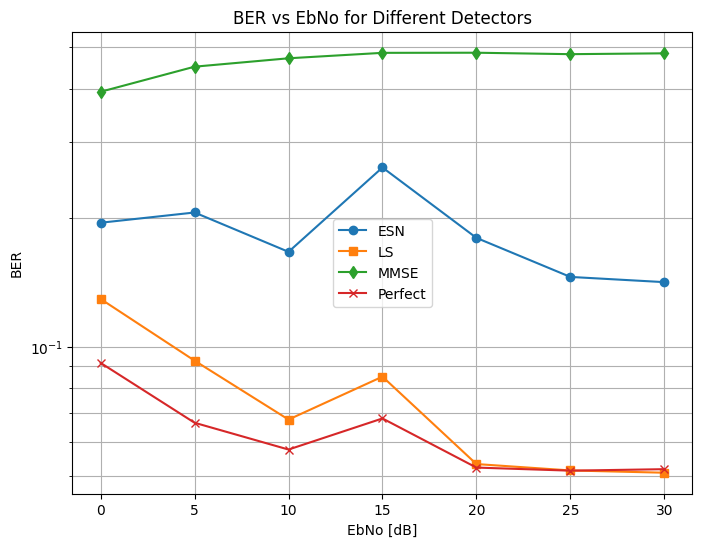

In [117]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate  # Assuming needed for interp1d
import sionna as sn  # Assuming Sionna imports: from sionna.channel import CDL, cir_to_time_channel, etc.
import tensorflow as tf

# Assume all helper functions and classes are defined here:
# class HelpFunc: ... (UnitQamConstellation, etc.)
# class ESN: ... 
# Sionna setup: carrier_frequency, delay_spread, bs_array, ut_array, cdl, etc.
# Parameters: N=64, N_t=2, N_r=2, m=4, m_pilot=4, IsiDuration=8, CyclicPrefixLen=7, No=0.00001, W=2*1.024e6, etc.
# Const = HelpFunc.UnitQamConstellation(m)
# ConstPilot = HelpFunc.UnitQamConstellation(m_pilot)
# PowersOfTwo = np.power(2, np.arange(m)).reshape((1, -1))
# R_h, IsiMagnitude, etc.
# ESN params: nInputUnits=4, nOutputUnits=4, nInternalUnits=500, spectralRadius=0.9, etc.
# DelayFlag=0, Min_Delay=0, Max_Delay=math.ceil(IsiDuration/2)+2
# Arrays: BER_ESN, etc. will be initialized below

# EbNo range
EbNoDB = np.arange(0, 35, 5)
num_snrs = len(EbNoDB)
Pi = np.zeros(num_snrs)
MMSEScaler = np.zeros(num_snrs)
BER_ESN = np.zeros(num_snrs)
BER_LS = np.zeros(num_snrs)
BER_MMSE = np.zeros(num_snrs)
BER_Perfect = np.zeros(num_snrs)
BLER_ESN = np.zeros(num_snrs)
BLER_LS = np.zeros(num_snrs)
BLER_MMSE = np.zeros(num_snrs)
BLER_Perfect = np.zeros(num_snrs)
NMSE_ESN_Testing = np.zeros(num_snrs)
NMSE_ESN_Training = np.zeros(num_snrs)
runtimes = np.zeros(num_snrs)

max_blocks = 10000  # Max data symbols per SNR
min_block_errors = 100  # Target for early stop per method

NumBitsPerSymbol = m * N

for jj in range(num_snrs):
    print(f"\n=== Processing SNR: EbNoDB = {EbNoDB[jj]} dB ===")
    start_time = time.time()

    # SNR-specific params
    var_x = np.power(10, (EbNoDB[jj] / 10)) * No * N
    Ptotal = var_x
    Pi[jj] = Ptotal / N
    A_Clip = np.sqrt(var_x) * np.float_power(10, ClipLeveldB / 20)
    inputScaling = inputScaler / (var_x ** 0.5) * np.ones(N_t * 2)
    inputShift = inputOffset / inputScaler * np.ones(N_t * 2)
    MMSEScaler[jj] = No / Pi[jj]
    MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler[jj] / (N / 2) * np.eye(IsiDuration))

    # Pilot symbol (kk=1)
    # Channel Generation using Sionna CDL
    batch_size = 1
    num_time_samples = 1
    a, tau = cdl(batch_size, num_time_samples, W)
    a = a.numpy()
    tau = tau.numpy()
    h_time = sn.channel.cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
    h_time = h_time.numpy()

    # Store channel
    for nnn in range(N_r):
        for mmm in range(N_t):
            c[nnn][mmm] = h_time[0, 0, nnn, 0, mmm, 0, :]
            Ci[nnn][mmm] = np.fft.fft(np.append(c[nnn][mmm], np.zeros(N - IsiDuration)))

    # Pilot Transmission
    TxBits = (np.random.uniform(0, 1, size=(N * m_pilot, N_t)) > 0.5).astype(np.int32)
    X = np.zeros((N, N_t)).astype('complex128')
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
    for ii in range(N):
        for iii in range(N_t):
            ThisQamIdx = np.matmul(PowersOfTwo[:m_pilot], TxBits[m_pilot * ii + np.arange(m_pilot), iii])
            X[ii, iii] = ConstPilot[ThisQamIdx[0]]
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

    # Nonlinear PA
    x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

    # Channel and Noise
    y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
            y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_CP_NLD[:, nnn] += noise
    Y = np.zeros((N, N_r)).astype('complex128')
    for nnn in range(N_r):
        Y[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

    # Orthogonal Pilots for LS
    X_LS = X.copy()
    X_LS[np.arange(1, len(X_LS), 2), 0] = 0
    X_LS[np.arange(0, len(X_LS), 2), 1] = 0
    x_LS_CP = np.zeros(x_CP.shape).astype('complex128')
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X_LS[:, iii])
        x_LS_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_LS_CP[:, iii] = x_LS_CP[:, iii] * (Pi[jj] ** 0.5)
    y_LS_CP = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_LS_CP[:, mmm], h_cdl, mode='full')
            y_LS_CP[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_LS_CP[:, nnn] += noise
    Y_LS = np.zeros((N, N_r)).astype('complex128')
    for nnn in range(N_r):
        Y_LS[:, nnn] = 1 / N * np.fft.fft(y_LS_CP[IsiDuration - 1:, nnn])
    Y_LS = Y_LS / (Pi[jj] ** 0.5)

    # LS and MMSE Channel Estimation
    for nnn in range(N_r):
        for mmm in range(N_t):
            Ci_LS_Pilots[nnn][mmm] = Y_LS[np.arange(mmm, len(Y_LS), 2), nnn] / X_LS[np.arange(mmm, len(X_LS), 2), mmm]
            c_LS = np.fft.ifft(Ci_LS_Pilots[nnn][mmm])[:IsiDuration]
            c_MMSE = np.matmul(MMSE_bold_TD, c_LS)
            Ci_MMSE[nnn][mmm] = np.fft.fft(np.append(c_MMSE, np.zeros(N - IsiDuration)))
            interp_x = np.append(np.arange(mmm, N, N_t), N - 1 if mmm == 0 else np.arange(mmm, N, N_t))
            interp_y = np.append(Ci_LS_Pilots[nnn][mmm], Ci_LS_Pilots[nnn][mmm][-1] if mmm == 0 else Ci_LS_Pilots[nnn][mmm])
            if mmm > 0:
                interp_x = np.append(0, interp_x)
                interp_y = np.append(Ci_LS_Pilots[nnn][mmm][0], interp_y)
            tmpf = interpolate.interp1d(interp_x, interp_y)
            Ci_LS[nnn][mmm] = tmpf(np.arange(N))

    # ESN Training
    esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
              sparsity=1 - min(0.2 * nInternalUnits, 1), input_shift=inputShift, input_scaling=inputScaling,
              teacher_scaling=teacherScaling, teacher_shift=teacherShift, feedback_scaling=feedbackScaling)
    [ESN_input, ESN_output, trainedEsn, Delay, Delay_Idx, Delay_Min, Delay_Max, nForgetPoints, NMSE_ESN] = \
        HelpFunc.trainMIMOESN(esn, DelayFlag, Min_Delay, Max_Delay, CyclicPrefixLen, N, N_t, N_r, IsiDuration, y_CP_NLD, x_CP)
    NMSE_ESN_Training[jj] = NMSE_ESN

    # Reset accumulators for this SNR
    TotalBerNum_ESN = 0
    TotalBerNum_LS = 0
    TotalBerNum_MMSE = 0
    TotalBerNum_Perfect = 0
    TotalBerDen = 0
    block_errors_ESN = 0
    block_errors_LS = 0
    block_errors_MMSE = 0
    block_errors_Perfect = 0
    num_blocks = 0
    NMSE_ESN_Testing[jj] = 0
    NMSE_count = 0

    while num_blocks < max_blocks and max(block_errors_ESN, block_errors_LS, block_errors_MMSE, block_errors_Perfect) < min_block_errors:
        num_blocks += 1
        # Data symbol processing
        TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
        X = np.zeros((N, N_t)).astype('complex128')
        x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
        for ii in range(N):
            for iii in range(N_t):
                ThisQamIdx = np.matmul(PowersOfTwo[:m], TxBits[m * ii + np.arange(m), iii])
                X[ii, iii] = Const[ThisQamIdx[0]]
        for iii in range(N_t):
            x_temp = N * np.fft.ifft(X[:, iii])
            x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
            x_CP[:, iii] = x_CP[:, iii] * (Pi[jj] ** 0.5)

        # Nonlinear PA
        x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))

        # Reception
        Y_NLD = np.zeros((N, N_r)).astype('complex128')
        y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
        for nnn in range(N_r):
            for mmm in range(N_t):
                h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
                conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
                y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
            noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
            y_CP_NLD[:, nnn] += noise
        for nnn in range(N_r):
            Y_NLD[:, nnn] = 1 / N * np.fft.fft(y_CP_NLD[IsiDuration - 1:, nnn])

        # ESN Detection
        ESN_input = np.zeros((N + Delay_Max + CyclicPrefixLen, N_t * 2))
        ESN_input[:, 0] = np.append(y_CP_NLD[:, 0].real, np.zeros(Delay_Max))
        ESN_input[:, 1] = np.append(y_CP_NLD[:, 0].imag, np.zeros(Delay_Max))
        ESN_input[:, 2] = np.append(y_CP_NLD[:, 1].real, np.zeros(Delay_Max))
        ESN_input[:, 3] = np.append(y_CP_NLD[:, 1].imag, np.zeros(Delay_Max))
        nForgetPoints = Delay_Min + CyclicPrefixLen
        x_hat_ESN_temp = trainedEsn.predict(ESN_input, continuation=False)[nForgetPoints:, :]
        x_hat_ESN_0 = x_hat_ESN_temp[Delay[0] - Delay_Min: Delay[0] - Delay_Min + N, 0] + 1j * x_hat_ESN_temp[Delay[1] - Delay_Min: Delay[1] - Delay_Min + N, 1]
        x_hat_ESN_1 = x_hat_ESN_temp[Delay[2] - Delay_Min: Delay[2] - Delay_Min + N, 2] + 1j * x_hat_ESN_temp[Delay[3] - Delay_Min: Delay[3] - Delay_Min + N, 3]
        x_hat_ESN_0 = x_hat_ESN_0.reshape(-1, 1)
        x_hat_ESN_1 = x_hat_ESN_1.reshape(-1, 1)
        x_hat_ESN = np.hstack((x_hat_ESN_0, x_hat_ESN_1))
        x = x_CP[IsiDuration - 1:, :]
        this_nmse = (
            np.linalg.norm(x_hat_ESN[:, 0] - x[:, 0]) ** 2 / np.linalg.norm(x[:, 0]) ** 2 +
            np.linalg.norm(x_hat_ESN[:, 1] - x[:, 1]) ** 2 / np.linalg.norm(x[:, 1]) ** 2
        )
        X_hat_ESN = np.zeros(X.shape).astype('complex128')
        for ii in range(N_t):
            X_hat_ESN[:, ii] = 1 / N * np.fft.fft(x_hat_ESN[:, ii]) / np.sqrt(Pi[jj])

        # Classical Detection
        H_temp = np.zeros((N_r, N_t)).astype('complex128')
        H_temp_LS = np.zeros((N_r, N_t)).astype('complex128')
        H_temp_MMSE = np.zeros((N_r, N_t)).astype('complex128')
        X_hat_Perfect = np.zeros(X.shape).astype('complex128')
        X_hat_LS = np.zeros(X.shape).astype('complex128')
        X_hat_MMSE = np.zeros(X.shape).astype('complex128')
        for ii in range(N):
            Y_temp = np.transpose(Y_NLD[ii, :])
            for nnn in range(N_r):
                for mmm in range(N_t):
                    H_temp[nnn, mmm] = Ci[nnn][mmm][ii]
                    H_temp_LS[nnn, mmm] = Ci_LS[nnn][mmm][ii]
                    H_temp_MMSE[nnn, mmm] = Ci_MMSE[nnn][mmm][ii]
            X_hat_Perfect[ii, :] = np.linalg.solve(H_temp, Y_temp) / np.sqrt(Pi[jj])
            X_hat_LS[ii, :] = np.linalg.solve(H_temp_LS, Y_temp) / np.sqrt(Pi[jj])
            X_hat_MMSE[ii, :] = np.linalg.solve(H_temp_MMSE, Y_temp) / np.sqrt(Pi[jj])

        # Bit Detection
        RxBits_ESN = np.zeros(TxBits.shape)
        RxBits_LS = np.zeros(TxBits.shape)
        RxBits_MMSE = np.zeros(TxBits.shape)
        RxBits_Perfect = np.zeros(TxBits.shape)
        for ii in range(N):
            for iii in range(N_t):
                # Perfect
                ThisQamIdx = np.argmin(np.abs(Const - X_hat_Perfect[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_Perfect[m * ii: m * (ii + 1), iii] = ThisBits
                # ESN
                ThisQamIdx = np.argmin(np.abs(Const - X_hat_ESN[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_ESN[m * ii: m * (ii + 1), iii] = ThisBits
                # LS
                ThisQamIdx = np.argmin(np.abs(Const - X_hat_LS[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_LS[m * ii: m * (ii + 1), iii] = ThisBits
                # MMSE
                ThisQamIdx = np.argmin(np.abs(Const - X_hat_MMSE[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(i) for i in ThisBits])[::-1]
                RxBits_MMSE[m * ii: m * (ii + 1), iii] = ThisBits

        bit_errors_ESN = np.sum(TxBits != RxBits_ESN)
        bit_errors_LS = np.sum(TxBits != RxBits_LS)
        bit_errors_MMSE = np.sum(TxBits != RxBits_MMSE)
        bit_errors_Perfect = np.sum(TxBits != RxBits_Perfect)

        TotalBerNum_ESN += bit_errors_ESN
        TotalBerNum_LS += bit_errors_LS
        TotalBerNum_MMSE += bit_errors_MMSE
        TotalBerNum_Perfect += bit_errors_Perfect
        TotalBerDen += NumBitsPerSymbol * N_t

        if bit_errors_ESN > 0: block_errors_ESN += 1
        if bit_errors_LS > 0: block_errors_LS += 1
        if bit_errors_MMSE > 0: block_errors_MMSE += 1
        if bit_errors_Perfect > 0: block_errors_Perfect += 1

        NMSE_ESN_Testing[jj] += this_nmse
        NMSE_count += 1

    # Averages
    BER_ESN[jj] = TotalBerNum_ESN / TotalBerDen if TotalBerDen > 0 else 0
    BER_LS[jj] = TotalBerNum_LS / TotalBerDen if TotalBerDen > 0 else 0
    BER_MMSE[jj] = TotalBerNum_MMSE / TotalBerDen if TotalBerDen > 0 else 0
    BER_Perfect[jj] = TotalBerNum_Perfect / TotalBerDen if TotalBerDen > 0 else 0
    BLER_ESN[jj] = block_errors_ESN / num_blocks if num_blocks > 0 else 0
    BLER_LS[jj] = block_errors_LS / num_blocks if num_blocks > 0 else 0
    BLER_MMSE[jj] = block_errors_MMSE / num_blocks if num_blocks > 0 else 0
    BLER_Perfect[jj] = block_errors_Perfect / num_blocks if num_blocks > 0 else 0
    NMSE_ESN_Testing[jj] /= NMSE_count if NMSE_count > 0 else 1

    runtimes[jj] = time.time() - start_time
    status = "reached max iter" if num_blocks >= max_blocks else "reached target block errors"

    # Print table (combined for all methods, or separate; here example for ESN)
    print("EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status")
    print("---------------------------------------------------------------------------------------------------------------------------------------")
    print(f"{EbNoDB[jj]:10.1f} | {BER_ESN[jj]:10.4e} | {BLER_ESN[jj]:10.4e} | {TotalBerNum_ESN:11} | {TotalBerDen:11} | {block_errors_ESN:12} | {num_blocks:11} | {runtimes[jj]:11.1f} | {status}")
    # Add lines for LS, MMSE, Perfect similarly

# Graph
plt.figure(figsize=(8, 6))
plt.semilogy(EbNoDB, BER_ESN, 'o-', label='ESN')
plt.semilogy(EbNoDB, BER_LS, 's-', label='LS')
plt.semilogy(EbNoDB, BER_MMSE, 'd-', label='MMSE')
plt.semilogy(EbNoDB, BER_Perfect, 'x-', label='Perfect')
plt.xlabel('EbNo [dB]')
plt.ylabel('BER')
plt.title('BER vs EbNo for Different Detectors')
plt.grid(True, which="both")
plt.legend()
plt.show()

# Save to CSV
data = np.column_stack((EbNoDB, BER_ESN, BLER_ESN, BER_LS, BLER_LS, BER_MMSE, BLER_MMSE, BER_Perfect, BLER_Perfect, NMSE_ESN_Training, NMSE_ESN_Testing, runtimes))
np.savetxt("mimo_ofdm_simulation_results_0_to_30dB.csv", data, delimiter=",", header="EbNo,BER_ESN,BLER_ESN,BER_LS,BLER_LS,BER_MMSE,BLER_MMSE,BER_Perfect,BLER_Perfect,NMSE_Train_ESN,NMSE_Test_ESN,Runtime", comments="")

Compare with different model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Set EbNo=20 dB
EbNoDB_fixed = 20
var_x = np.power(10, EbNoDB_fixed / 10) * No * N
Ptotal_fixed = var_x
Pi_fixed = Ptotal_fixed / N
A_Clip = np.sqrt(var_x) * np.float_power(10, ClipLeveldB / 20)
MMSEScaler_fixed = No / Pi_fixed
MMSE_bold_TD = np.linalg.inv(R_h + MMSEScaler_fixed / (N / 2) * np.eye(IsiDuration))

# Generate channel once (static)
batch_size = 1
num_time_samples = 1
a, tau = cdl(batch_size, num_time_samples, W)
a = a.numpy()
tau = tau.numpy()
h_time = sn.channel.cir_to_time_channel(W, a, tau, l_min=0, l_max=IsiDuration-1, normalize=True)
h_time = h_time.numpy()

# Function to generate one symbol (pilot or data)
def generate_symbol(is_pilot=False):
    if is_pilot:
        TxBits = (np.random.uniform(0, 1, size=(N * m_pilot, N_t)) > 0.5).astype(np.int32)
        Const_used = ConstPilot
        m_used = m_pilot
    else:
        TxBits = (np.random.uniform(0, 1, size=(N * m, N_t)) > 0.5).astype(np.int32)
        Const_used = Const
        m_used = m
    X = np.zeros((N, N_t)).astype('complex128')
    for ii in range(N):
        for iii in range(N_t):
            ThisQamIdx = np.matmul(PowersOfTwo[:m_used], TxBits[m_used * ii + np.arange(m_used), iii])
            X[ii, iii] = Const_used[ThisQamIdx[0]]
    x_CP = np.zeros((N + CyclicPrefixLen, N_t)).astype('complex128')
    for iii in range(N_t):
        x_temp = N * np.fft.ifft(X[:, iii])
        x_CP[:, iii] = np.append(x_temp[-(CyclicPrefixLen):], x_temp)
        x_CP[:, iii] = x_CP[:, iii] * np.sqrt(Pi_fixed)
    x_CP_NLD = x_CP / ((1 + (np.abs(x_CP) / A_Clip) ** (2 * p_smooth)) ** (1 / (2 * p_smooth)))
    y_CP_NLD = np.zeros((N + CyclicPrefixLen, N_r)).astype('complex128')
    for nnn in range(N_r):
        for mmm in range(N_t):
            h_cdl = h_time[0, 0, nnn, 0, mmm, 0, :]
            conv_result = np.convolve(x_CP_NLD[:, mmm], h_cdl, mode='full')
            y_CP_NLD[:, nnn] += conv_result[:N + CyclicPrefixLen]
        noise = np.sqrt(No / 2) * (np.random.normal(size=(N + CyclicPrefixLen)) + 1j * np.random.normal(size=(N + CyclicPrefixLen)))
        y_CP_NLD[:, nnn] += noise
    # ESN-like input/output (real/imag, padded)
    input_data = np.zeros((N + CyclicPrefixLen, 4))
    input_data[:, 0] = y_CP_NLD[:, 0].real
    input_data[:, 1] = y_CP_NLD[:, 0].imag
    input_data[:, 2] = y_CP_NLD[:, 1].real
    input_data[:, 3] = y_CP_NLD[:, 1].imag
    output_data = np.zeros((N + CyclicPrefixLen, 4))
    output_data[:, 0] = x_CP[:, 0].real
    output_data[:, 1] = x_CP[:, 0].imag
    output_data[:, 2] = x_CP[:, 1].real
    output_data[:, 3] = x_CP[:, 1].imag
    return input_data, output_data, X, TxBits, y_CP_NLD  # Return for later use if needed

# Generate datasets
num_train = 100  # Pilots for training
num_test = 1000  # Data for testing
train_inputs = []
train_outputs = []
test_inputs = []
test_outputs = []
test_X_list = []  # For BER calculation
test_TxBits_list = []
for i in range(num_train):
    inp, out, _, _, _ = generate_symbol(is_pilot=True)
    train_inputs.append(inp)
    train_outputs.append(out)
for i in range(num_test):
    inp, out, X, TxBits, y_CP_NLD = generate_symbol(is_pilot=False)
    test_inputs.append(inp)
    test_outputs.append(out)
    test_X_list.append(X)
    test_TxBits_list.append(TxBits)

train_inputs = np.array(train_inputs)  # (100, time_steps, 4)
train_outputs = np.array(train_outputs)
test_inputs = np.array(test_inputs)  # (1000, time_steps, 4)
test_outputs = np.array(test_outputs)

print(f"Train shapes: Inputs {train_inputs.shape}, Outputs {train_outputs.shape}")
print(f"Test shapes: Inputs {test_inputs.shape}, Outputs {test_outputs.shape}")


Train shapes: Inputs (100, 71, 4), Outputs (100, 71, 4)
Test shapes: Inputs (1000, 71, 4), Outputs (1000, 71, 4)
Data preparation complete. Understand?


In [140]:
# Block 2: Train and Evaluate ESN (Updated)
nInputUnits = 4
nOutputUnits = 4
nInternalUnits = 500
spectralRadius = 0.9
inputScaler = 0.005 / np.sqrt(var_x)
teacherScaling = 0.0000005
feedbackScaling = 0.0
noise = 0.001
sparsity = 0.0
teacherShift = np.zeros(4)
inputShift = np.zeros(4)

# Train ESN
train_inputs_flat = train_inputs.reshape(-1, 4)
train_outputs_flat = train_outputs.reshape(-1, 4)

esn = ESN(n_inputs=nInputUnits, n_outputs=nOutputUnits, n_reservoir=nInternalUnits, spectral_radius=spectralRadius,
          sparsity=sparsity, noise=noise, input_shift=inputShift, input_scaling=inputScaler * np.ones(4),
          teacher_scaling=teacherScaling * np.ones(4), teacher_shift=teacherShift,
          feedback_scaling=feedbackScaling * np.ones(4), random_state=42)

esn.fit(train_inputs_flat, train_outputs_flat, nForgetPoints=0)

# Predict on test and save
test_pred_esn = []
test_nmse_esn = 0
ber_esn = 0
for i in range(num_test):
    inp = test_inputs[i]
    out_true = test_outputs[i]
    out_pred = esn.predict(inp)
    test_pred_esn.append(out_pred)
    this_nmse = np.mean(np.linalg.norm(out_pred - out_true, axis=1)**2 / np.linalg.norm(out_true, axis=1)**2)
    test_nmse_esn += this_nmse

test_pred_esn = np.array(test_pred_esn)
test_nmse_esn /= num_test
print(f"ESN Test NMSE: {test_nmse_esn:.6f}")
print(f"ESN Predictions Shape: {test_pred_esn.shape}")


ESN Test NMSE: 0.170109
ESN Predictions Shape: (1000, 71, 4)


In [142]:
# Block 3: Train and Evaluate FFNN (Updated)
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Flatten inputs/outputs for FFNN
time_steps, features = train_inputs.shape[1], train_inputs.shape[2]
train_inputs_flat = train_inputs.reshape(num_train, -1)  # (100, 71*4)
train_outputs_flat = train_outputs.reshape(num_train, -1)  # (100, 71*4)
test_inputs_flat = test_inputs.reshape(num_test, -1)
test_outputs_flat = test_outputs.reshape(num_test, -1)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(train_inputs_flat, train_outputs_flat, test_size=0.2, random_state=42)

# Build FFNN model
ffnn = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(time_steps * features,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(time_steps * features)  # Linear output
])
ffnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = ffnn.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# Predict and save
test_pred_flat = ffnn.predict(test_inputs_flat)
test_pred_ffnn = test_pred_flat.reshape(num_test, time_steps, features)

# Compute NMSE
test_nmse_ffnn = 0
for i in range(num_test):
    this_nmse = np.mean(np.linalg.norm(test_pred_ffnn[i] - test_outputs[i], axis=1)**2 / np.linalg.norm(test_outputs[i], axis=1)**2)
    test_nmse_ffnn += this_nmse
test_nmse_ffnn /= num_test

print(f"FFNN Test NMSE: {test_nmse_ffnn:.6f}")
print(f"FFNN Predictions Shape: {test_pred_ffnn.shape}")


Epoch 1/200
3/3 [==============================] - 1s 58ms/step - loss: 0.0341 - mae: 0.1474 - val_loss: 0.0329 - val_mae: 0.1444
Epoch 2/200
3/3 [==============================] - 0s 15ms/step - loss: 0.0314 - mae: 0.1414 - val_loss: 0.0326 - val_mae: 0.1439
Epoch 3/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0307 - mae: 0.1399 - val_loss: 0.0326 - val_mae: 0.1440
Epoch 4/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0301 - mae: 0.1384 - val_loss: 0.0328 - val_mae: 0.1442
Epoch 5/200
3/3 [==============================] - 0s 14ms/step - loss: 0.0294 - mae: 0.1368 - val_loss: 0.0330 - val_mae: 0.1446
Epoch 6/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0286 - mae: 0.1350 - val_loss: 0.0332 - val_mae: 0.1450
Epoch 7/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0278 - mae: 0.1330 - val_loss: 0.0333 - val_mae: 0.1453
Epoch 8/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0270 - mae: 0.13

In [144]:
# Block 4: Train and Evaluate CNN
# No flatten; keep as (samples, time_steps, features)
# Train/test split
train_inputs_seq = train_inputs  # Already (100, 71, 4)
train_outputs_seq = train_outputs
X_train, X_val, y_train, y_val = train_test_split(train_inputs_seq, train_outputs_seq, test_size=0.2, random_state=42)

# Build CNN model
cnn = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(time_steps, features)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(time_steps * features),
    layers.Reshape((time_steps, features))  # Output shape match
])
cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = cnn.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# Predict on test
test_pred = cnn.predict(test_inputs)

# Compute NMSE
test_nmse_cnn = 0
for i in range(num_test):
    this_nmse = np.mean(np.linalg.norm(test_pred[i] - test_outputs[i], axis=1)**2 / np.linalg.norm(test_outputs[i], axis=1)**2)
    test_nmse_cnn += this_nmse
test_nmse_cnn /= num_test

# BER placeholder
ber_cnn = 0  # Implement as before

print(f"CNN Test NMSE: {test_nmse_cnn:.6f}")


# Save predictions for later use
test_pred_cnn = test_pred

Epoch 1/200
3/3 [==============================] - 1s 60ms/step - loss: 0.0328 - mae: 0.1446 - val_loss: 0.0326 - val_mae: 0.1440
Epoch 2/200
3/3 [==============================] - 0s 17ms/step - loss: 0.0316 - mae: 0.1420 - val_loss: 0.0325 - val_mae: 0.1438
Epoch 3/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0312 - mae: 0.1410 - val_loss: 0.0325 - val_mae: 0.1438
Epoch 4/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0307 - mae: 0.1400 - val_loss: 0.0329 - val_mae: 0.1446
Epoch 5/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0302 - mae: 0.1387 - val_loss: 0.0332 - val_mae: 0.1453
Epoch 6/200
3/3 [==============================] - 0s 15ms/step - loss: 0.0295 - mae: 0.1371 - val_loss: 0.0333 - val_mae: 0.1456
Epoch 7/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0287 - mae: 0.1352 - val_loss: 0.0333 - val_mae: 0.1456
Epoch 8/200
3/3 [==============================] - 0s 15ms/step - loss: 0.0278 - mae: 0.13

In [145]:
# Block 5: Train and Evaluate RNN (LSTM)
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Use sequence inputs/outputs
X_train, X_val, y_train, y_val = train_test_split(train_inputs, train_outputs, test_size=0.2, random_state=42)

# Build RNN (LSTM) model
rnn = models.Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(time_steps, features)),
    layers.LSTM(64, return_sequences=True),
    layers.Dense(features)  # Linear output for regression, per time step
])
rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = rnn.fit(X_train, y_train, epochs=400, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# Predict on test
test_pred = rnn.predict(test_inputs)

# Compute NMSE
test_nmse_rnn = 0
for i in range(num_test):
    this_nmse = np.mean(np.linalg.norm(test_pred[i] - test_outputs[i], axis=1)**2 / np.linalg.norm(test_outputs[i], axis=1)**2)
    test_nmse_rnn += this_nmse
test_nmse_rnn /= num_test

# BER placeholder (implement as before)
ber_rnn = 0  # Add your BER calculation here using test_pred

print(f"RNN Test NMSE: {test_nmse_rnn:.6f}")

# Save predictions for later use
test_pred_rnn = test_pred

Epoch 1/400
3/3 [==============================] - 2s 250ms/step - loss: 0.0319 - mae: 0.1426 - val_loss: 0.0318 - val_mae: 0.1422
Epoch 2/400
3/3 [==============================] - 0s 44ms/step - loss: 0.0315 - mae: 0.1416 - val_loss: 0.0315 - val_mae: 0.1414
Epoch 3/400
3/3 [==============================] - 0s 42ms/step - loss: 0.0312 - mae: 0.1408 - val_loss: 0.0312 - val_mae: 0.1406
Epoch 4/400
3/3 [==============================] - 0s 42ms/step - loss: 0.0308 - mae: 0.1399 - val_loss: 0.0308 - val_mae: 0.1397
Epoch 5/400
3/3 [==============================] - 0s 41ms/step - loss: 0.0305 - mae: 0.1391 - val_loss: 0.0304 - val_mae: 0.1388
Epoch 6/400
3/3 [==============================] - 0s 41ms/step - loss: 0.0301 - mae: 0.1382 - val_loss: 0.0301 - val_mae: 0.1379
Epoch 7/400
3/3 [==============================] - 0s 42ms/step - loss: 0.0298 - mae: 0.1373 - val_loss: 0.0296 - val_mae: 0.1368
Epoch 8/400
3/3 [==============================] - 0s 67ms/step - loss: 0.0294 - mae: 0.1

ESN: NMSE=0.170109, BER=0.053896
FFNN: NMSE=1.021743, BER=0.498439
CNN: NMSE=1.013758, BER=0.499861
RNN: NMSE=0.162312, BER=0.045068


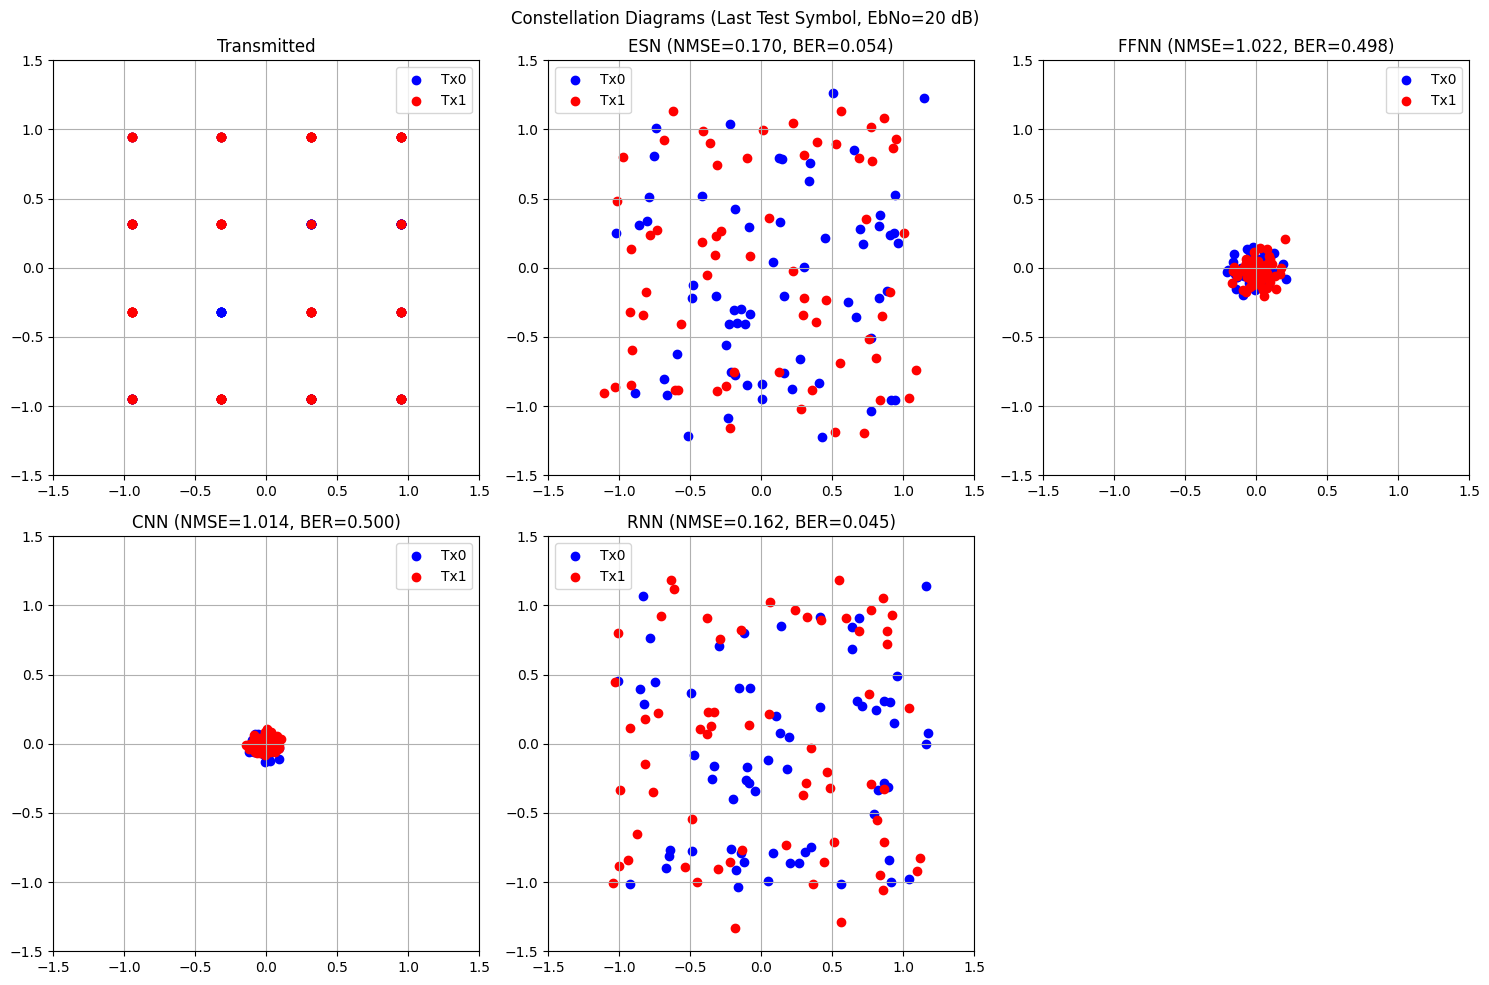

Results saved to 'mimo_ofdm_dl_comparison_ebno20dB.csv'


In [146]:
# Block 6: Full Comparison with Constellation Plots and CSV Output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# No resets - assume predictions are already set from previous blocks: test_pred_esn, test_pred_ffnn, test_pred_cnn, test_pred_rnn
# Add checks to ensure predictions are populated and convert to array if necessary

if 'test_pred_esn' not in globals() or len(test_pred_esn) == 0:
    raise ValueError("test_pred_esn is not defined or empty. Please run Block 2 first to populate it.")
test_pred_esn = np.array(test_pred_esn) if not isinstance(test_pred_esn, np.ndarray) else test_pred_esn
assert test_pred_esn.shape[0] == num_test, f"test_pred_esn has wrong number of samples: {test_pred_esn.shape[0]} instead of {num_test}"

if 'test_pred_ffnn' not in globals() or len(test_pred_ffnn) == 0:
    raise ValueError("test_pred_ffnn is not defined or empty. Please run Block 3 first to populate it.")
test_pred_ffnn = np.array(test_pred_ffnn) if not isinstance(test_pred_ffnn, np.ndarray) else test_pred_ffnn
assert test_pred_ffnn.shape[0] == num_test, f"test_pred_ffnn has wrong number of samples: {test_pred_ffnn.shape[0]} instead of {num_test}"

if 'test_pred_cnn' not in globals() or len(test_pred_cnn) == 0:
    raise ValueError("test_pred_cnn is not defined or empty. Please run Block 4 first to populate it.")
test_pred_cnn = np.array(test_pred_cnn) if not isinstance(test_pred_cnn, np.ndarray) else test_pred_cnn
assert test_pred_cnn.shape[0] == num_test, f"test_pred_cnn has wrong number of samples: {test_pred_cnn.shape[0]} instead of {num_test}"

if 'test_pred_rnn' not in globals() or len(test_pred_rnn) == 0:
    raise ValueError("test_pred_rnn is not defined or empty. Please run Block 5 first to populate it.")
test_pred_rnn = np.array(test_pred_rnn) if not isinstance(test_pred_rnn, np.ndarray) else test_pred_rnn
assert test_pred_rnn.shape[0] == num_test, f"test_pred_rnn has wrong number of samples: {test_pred_rnn.shape[0]} instead of {num_test}"

# Function to compute BER (adapted from your original code)
def compute_ber(test_pred, test_X_list, test_TxBits_list):
    ber = 0
    num_bits = 0
    for i in range(num_test):
        # Reconstruct complex signal (for both Tx antennas)
        x_hat = np.zeros((N, N_t), dtype=complex)
        x_hat[:, 0] = test_pred[i][CyclicPrefixLen:, 0] + 1j * test_pred[i][CyclicPrefixLen:, 1]
        x_hat[:, 1] = test_pred[i][CyclicPrefixLen:, 2] + 1j * test_pred[i][CyclicPrefixLen:, 3]
        X_hat = np.zeros((N, N_t), dtype=complex)
        for iii in range(N_t):
            X_hat[:, iii] = np.fft.fft(x_hat[:, iii]) / (N * np.sqrt(Pi_fixed))
        # Bit detection
        RxBits = np.zeros((N * m, N_t))
        for ii in range(N):
            for iii in range(N_t):
                ThisQamIdx = np.argmin(np.abs(Const - X_hat[ii, iii]))
                ThisBits = list(format(ThisQamIdx, 'b').zfill(m))
                ThisBits = np.array([int(b) for b in ThisBits])[::-1]
                RxBits[m * ii:m * (ii + 1), iii] = ThisBits
        ber += np.sum(test_TxBits_list[i] != RxBits)
        num_bits += N * m * N_t
    return ber / num_bits if num_bits > 0 else 0

# Compute BER for each model
ber_esn = compute_ber(test_pred_esn, test_X_list, test_TxBits_list)
ber_ffnn = compute_ber(test_pred_ffnn, test_X_list, test_TxBits_list)
ber_cnn = compute_ber(test_pred_cnn, test_X_list, test_TxBits_list)
ber_rnn = compute_ber(test_pred_rnn, test_X_list, test_TxBits_list)

# Print NMSE and BER
print(f"ESN: NMSE={test_nmse_esn:.6f}, BER={ber_esn:.6f}")
print(f"FFNN: NMSE={test_nmse_ffnn:.6f}, BER={ber_ffnn:.6f}")
print(f"CNN: NMSE={test_nmse_cnn:.6f}, BER={ber_cnn:.6f}")
print(f"RNN: NMSE={test_nmse_rnn:.6f}, BER={ber_rnn:.6f}")

# Constellation plot for last test symbol
last_idx = num_test - 1
X_true = test_X_list[last_idx]
X_hat_esn = np.zeros((N, N_t), dtype=complex)
X_hat_ffnn = np.zeros((N, N_t), dtype=complex)
X_hat_cnn = np.zeros((N, N_t), dtype=complex)
X_hat_rnn = np.zeros((N, N_t), dtype=complex)
for iii in range(N_t):
    x_hat_esn = test_pred_esn[last_idx][CyclicPrefixLen:, iii*2] + 1j * test_pred_esn[last_idx][CyclicPrefixLen:, iii*2+1]
    x_hat_ffnn = test_pred_ffnn[last_idx][CyclicPrefixLen:, iii*2] + 1j * test_pred_ffnn[last_idx][CyclicPrefixLen:, iii*2+1]
    x_hat_cnn = test_pred_cnn[last_idx][CyclicPrefixLen:, iii*2] + 1j * test_pred_cnn[last_idx][CyclicPrefixLen:, iii*2+1]
    x_hat_rnn = test_pred_rnn[last_idx][CyclicPrefixLen:, iii*2] + 1j * test_pred_rnn[last_idx][CyclicPrefixLen:, iii*2+1]
    X_hat_esn[:, iii] = np.fft.fft(x_hat_esn) / (N * np.sqrt(Pi_fixed))
    X_hat_ffnn[:, iii] = np.fft.fft(x_hat_ffnn) / (N * np.sqrt(Pi_fixed))
    X_hat_cnn[:, iii] = np.fft.fft(x_hat_cnn) / (N * np.sqrt(Pi_fixed))
    X_hat_rnn[:, iii] = np.fft.fft(x_hat_rnn) / (N * np.sqrt(Pi_fixed))

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Constellation Diagrams (Last Test Symbol, EbNo=20 dB)')
# Transmitted
axs[0, 0].scatter(X_true[:, 0].real, X_true[:, 0].imag, c='b', label='Tx0')
axs[0, 0].scatter(X_true[:, 1].real, X_true[:, 1].imag, c='r', label='Tx1')
axs[0, 0].set_title('Transmitted')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_xlim([-1.5, 1.5])
axs[0, 0].set_ylim([-1.5, 1.5])
# ESN
axs[0, 1].scatter(X_hat_esn[:, 0].real, X_hat_esn[:, 0].imag, c='b', label='Tx0')
axs[0, 1].scatter(X_hat_esn[:, 1].real, X_hat_esn[:, 1].imag, c='r', label='Tx1')
axs[0, 1].set_title(f'ESN (NMSE={test_nmse_esn:.3f}, BER={ber_esn:.3f})')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_xlim([-1.5, 1.5])
axs[0, 1].set_ylim([-1.5, 1.5])
# FFNN
axs[0, 2].scatter(X_hat_ffnn[:, 0].real, X_hat_ffnn[:, 0].imag, c='b', label='Tx0')
axs[0, 2].scatter(X_hat_ffnn[:, 1].real, X_hat_ffnn[:, 1].imag, c='r', label='Tx1')
axs[0, 2].set_title(f'FFNN (NMSE={test_nmse_ffnn:.3f}, BER={ber_ffnn:.3f})')
axs[0, 2].legend()
axs[0, 2].grid(True)
axs[0, 2].set_xlim([-1.5, 1.5])
axs[0, 2].set_ylim([-1.5, 1.5])
# CNN
axs[1, 0].scatter(X_hat_cnn[:, 0].real, X_hat_cnn[:, 0].imag, c='b', label='Tx0')
axs[1, 0].scatter(X_hat_cnn[:, 1].real, X_hat_cnn[:, 1].imag, c='r', label='Tx1')
axs[1, 0].set_title(f'CNN (NMSE={test_nmse_cnn:.3f}, BER={ber_cnn:.3f})')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_xlim([-1.5, 1.5])
axs[1, 0].set_ylim([-1.5, 1.5])
# RNN
axs[1, 1].scatter(X_hat_rnn[:, 0].real, X_hat_rnn[:, 0].imag, c='b', label='Tx0')
axs[1, 1].scatter(X_hat_rnn[:, 1].real, X_hat_rnn[:, 1].imag, c='r', label='Tx1')
axs[1, 1].set_title(f'RNN (NMSE={test_nmse_rnn:.3f}, BER={ber_rnn:.3f})')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_xlim([-1.5, 1.5])
axs[1, 1].set_ylim([-1.5, 1.5])
# Hide empty subplot
axs[1, 2].axis('off')
plt.tight_layout()
plt.show()

# Save results to CSV
results = {
    'Model': ['ESN', 'FFNN', 'CNN', 'RNN'],
    'NMSE': [test_nmse_esn, test_nmse_ffnn, test_nmse_cnn, test_nmse_rnn],
    'BER': [ber_esn, ber_ffnn, ber_cnn, ber_rnn]
}
df = pd.DataFrame(results)
df.to_csv('mimo_ofdm_dl_comparison_ebno20dB.csv', index=False)
print("Results saved to 'mimo_ofdm_dl_comparison_ebno20dB.csv'")
